# 3. Model Training 

In [1]:
# import numpy for math calculations
import numpy as np

# import pandas for data (csv) manipulation
import pandas as pd

# import matplotlib for plotting
import matplotlib.pyplot as plt

import sys  
sys.path.insert(1, '../src/')

from train_model import ClassifierEvaluator
from visualize import VisualizationUtils
import seaborn as sns
# import shap for ai explainability
import shap

from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn import tree

# import warnings to hide the unnessairy warniings
import warnings
warnings.filterwarnings('ignore')

c:\Users\Benhamadi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mov_slow = pd.read_csv('../data/processed/movement_slow_stat_cleaned.csv').drop(columns=['Unnamed: 0']).fillna(0)
mov_fast = pd.read_csv('../data/processed/movement_fast_stat_cleaned.csv').drop(columns=['Unnamed: 0']).fillna(0)
traffic_slow = pd.read_csv('../data/processed/traffic_slow_stat_cleaned.csv', index_col=0).fillna(0)
traffic_fast = pd.read_csv('../data/processed/traffic_fast_stat_cleaned.csv', index_col=0).fillna(0)

In [3]:
for col in mov_fast.columns.values:
    if "PosY" in col and "Accel" not in col and "Velocity" not in col:
        print(col)
        for id in range(60):
            #print(id, col, mov_fast.loc[mov_fast['ID'] == id][col])
            print(id, col, np.mean(mov_fast.loc[mov_fast['ID'] == id,col]), np.max(mov_fast.loc[mov_fast['ID'] == id,col]), np.min(mov_fast.loc[mov_fast['ID'] == id,col]))
            mov_fast.loc[mov_fast['ID'] == id,col] = mov_fast.loc[mov_fast['ID'] == id,col] / np.mean(mov_fast.loc[mov_fast['ID'] == id,col])
            print(id, col, np.mean(mov_fast.loc[mov_fast['ID'] == id,col]), np.max(mov_fast.loc[mov_fast['ID'] == id,col]), np.min(mov_fast.loc[mov_fast['ID'] == id,col]))
            mov_slow.loc[mov_slow['ID'] == id,col] = mov_slow.loc[mov_slow['ID'] == id,col] / np.mean(mov_fast.loc[mov_fast['ID'] == id,col])

HeadPosY_25%
0 HeadPosY_25% 0.7134620286105323 0.7278551096508605 0.6570334403533158
0 HeadPosY_25% 0.9999999999999999 1.0201735768171976 0.9209087716032888
1 HeadPosY_25% 0.7788999002622312 0.8124401626932196 0.2526097097609505
1 HeadPosY_25% 0.9999999999999998 1.0430610691048958 0.3243160124630966
2 HeadPosY_25% 0.9066900340050817 0.9214591842635648 0.7479711538667484
2 HeadPosY_25% 1.0000000000000002 1.0162890841462588 0.824946923220021
3 HeadPosY_25% 0.8121922818530807 0.8303501245472713 0.7458421772961998
3 HeadPosY_25% 1.0 1.0223565811937563 0.918307393409972
4 HeadPosY_25% 0.8161531278178419 0.8245928921311398 0.7965606533430714
4 HeadPosY_25% 1.0 1.0103409078831365 0.9759941194771192
5 HeadPosY_25% 0.8564253755159127 0.9103195392500604 0.7888929107650393
5 HeadPosY_25% 0.9999999999999999 1.0629291999920971 0.9211461188779096
6 HeadPosY_25% 0.8777812166008767 0.8872263547594619 0.8320635865758819
6 HeadPosY_25% 1.0 1.0107602418233106 0.9479168280656176
7 HeadPosY_25% 0.857940040

## 3.1. Movement Data
### 3.1.1. Training On Cooking Similator

In [4]:
evaluator = ClassifierEvaluator()
X, y, fX, fy, X_train, y_train, X_test, y_test, fX_train, fy_train, fX_test, fy_test = evaluator.split_data(mov_slow, mov_fast, id_range=range(0,30), train_minutes=8, test_minutes=2)

Size of the training set:  (1437, 462)
Size of the slow testing set:  (360, 462)
Size of the fast training set:  (1440, 462)
Size of the fast testing set:  (360, 462)


In [5]:
Accuracy_set, models, best_model_slow, best_model_fast, cm_slow, cm_fast, best_model_slow_name, best_model_fast_name = evaluator.evaluate_classifiers(X_train,y_train,X_test,y_test,fX_test,fy_test)
Accuracy_set.sort_values(by='Accuracy(Slow)').style.background_gradient(cmap= plt.cm.Blues)

100%|██████████| 15/15 [07:09<00:00, 28.62s/it]


,Model,Accuracy(Train),Accuracy(Slow),Accuracy(Fast),F1(Train),F1(Slow),F1(Fast),Precision(Train),Precision(Slow),Precision(Fast),Recall(Train),Recall(Slow),Recall(Fast),Log_loss(Train),Log_loss(Slow),Log_loss(Fast)
7,AdaBoostClassifier,0.041754,0.044444,0.036111,0.012068,0.016416,0.006466,0.014134,0.020282,0.009524,0.041667,0.044444,0.036111,3.327380,3.276759,4.419064
9,QuadraticDiscriminantAnalysis,1.000000,0.069444,0.036111,1.000000,0.069249,0.033258,1.000000,0.076851,0.036121,1.000000,0.069444,0.036111,0.000000,33.540622,34.742077
11,BernoulliNB,0.128740,0.072222,0.072222,0.126275,0.024559,0.037270,0.751373,0.021769,0.029011,0.128519,0.072222,0.072222,3.249317,3.349767,3.940384
0,SVC,0.579680,0.441667,0.050000,0.551716,0.397727,0.017861,0.629134,0.467877,0.012368,0.578472,0.441667,0.050000,3.410821,3.408735,3.401546
4,KNeighborsClassifier,0.868476,0.575000,0.055556,0.866698,0.557342,0.032956,0.880069,0.621547,0.058227,0.868565,0.575000,0.055556,0.316106,7.462050,31.595880
3,DecisionTreeClassifier,1.000000,0.591667,0.030556,1.000000,0.566924,0.017740,1.000000,0.587297,0.033180,1.000000,0.591667,0.030556,0.000000,14.717825,34.942320
8,GaussianNB,0.846903,0.630556,0.052778,0.845422,0.636860,0.021412,0.862602,0.703925,0.032728,0.846991,0.630556,0.052778,4.273149,10.754754,34.053921
2,LinearDiscriminantAnalysis,0.984690,0.647222,0.069444,0.984634,0.630255,0.043266,0.985364,0.653402,0.059251,0.984676,0.647222,0.069444,0.083710,5.271833,30.929416
12,BaggingClassifier,0.999304,0.702778,0.038889,0.999305,0.673647,0.015194,0.999320,0.687979,0.011189,0.999306,0.702778,0.038889,0.131047,3.810323,30.340475
10,LogisticRegression,0.972860,0.741667,0.036111,0.972668,0.724727,0.015486,0.973331,0.736378,0.036637,0.972917,0.741667,0.036111,0.332331,0.942912,9.670774


In [6]:
explainer = shap.TreeExplainer(best_model_slow)
shap_values_slow = explainer.shap_values(X_test)

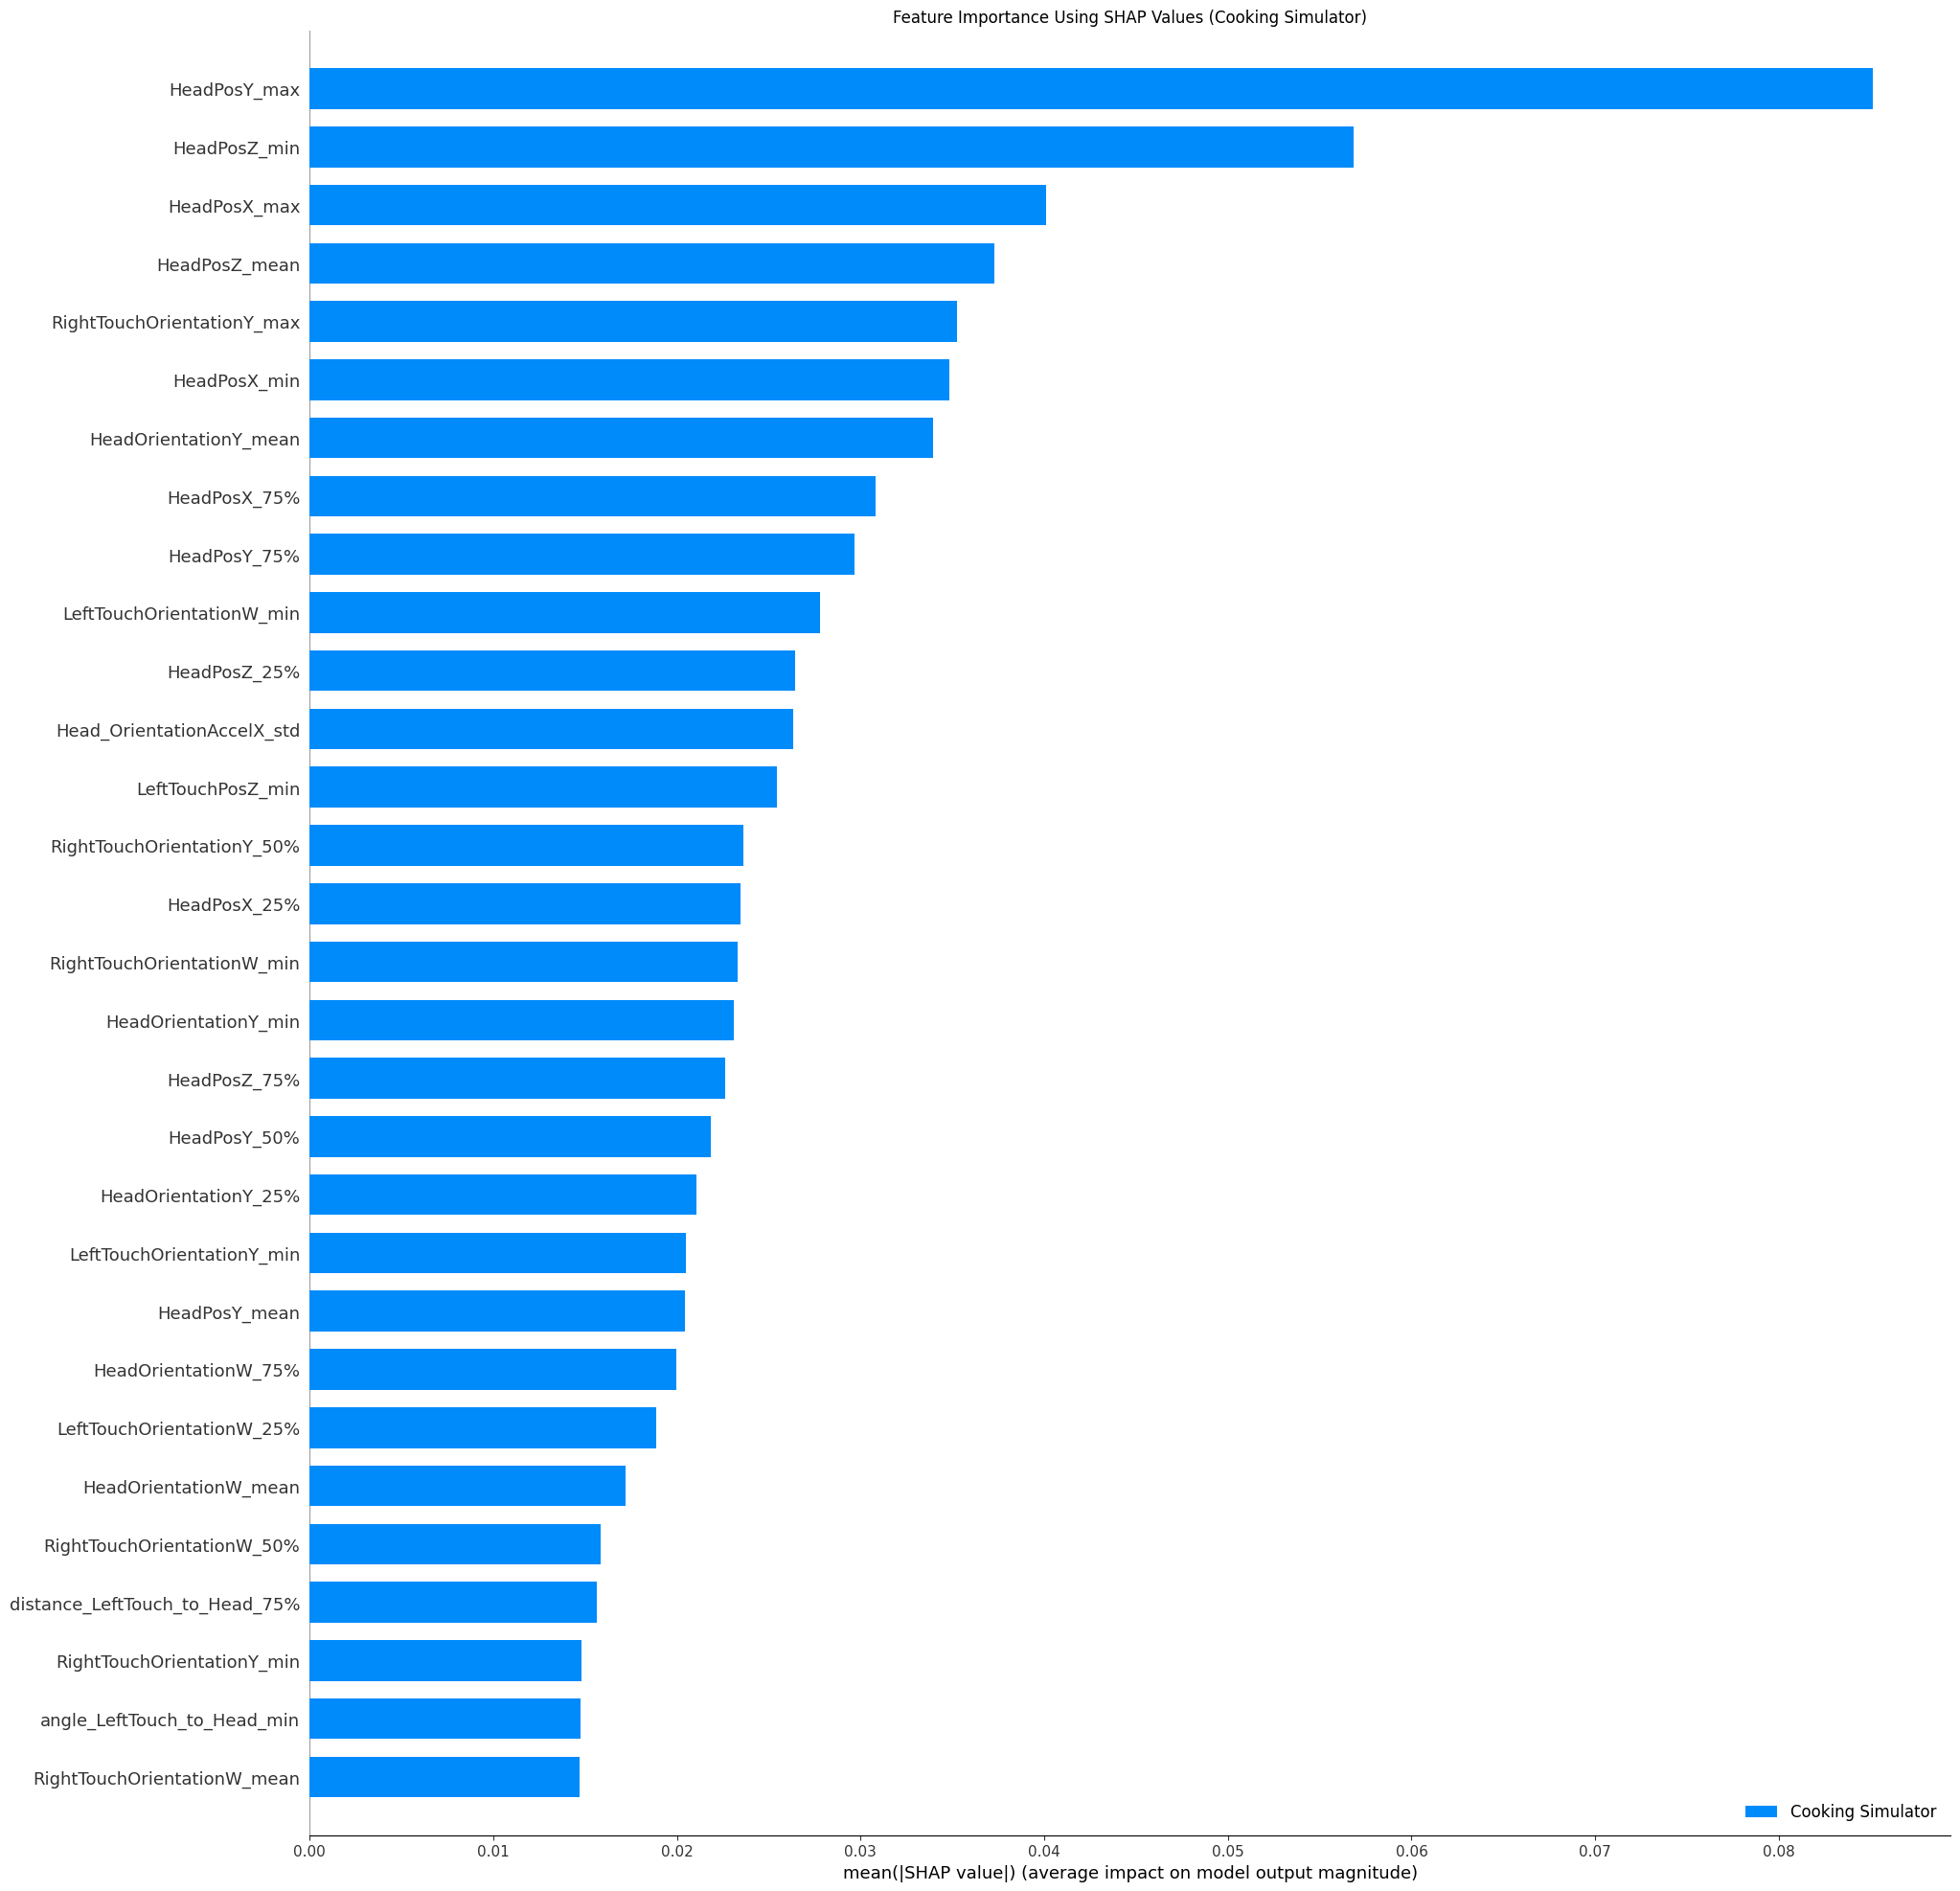

In [7]:
VisualizationUtils.shap_plotter([np.mean(shap_values_slow, axis=2)], 
                          X_test, title="Feature Importance Using SHAP Values (Cooking Simulator)",
                          class_names=['Cooking Simulator'])

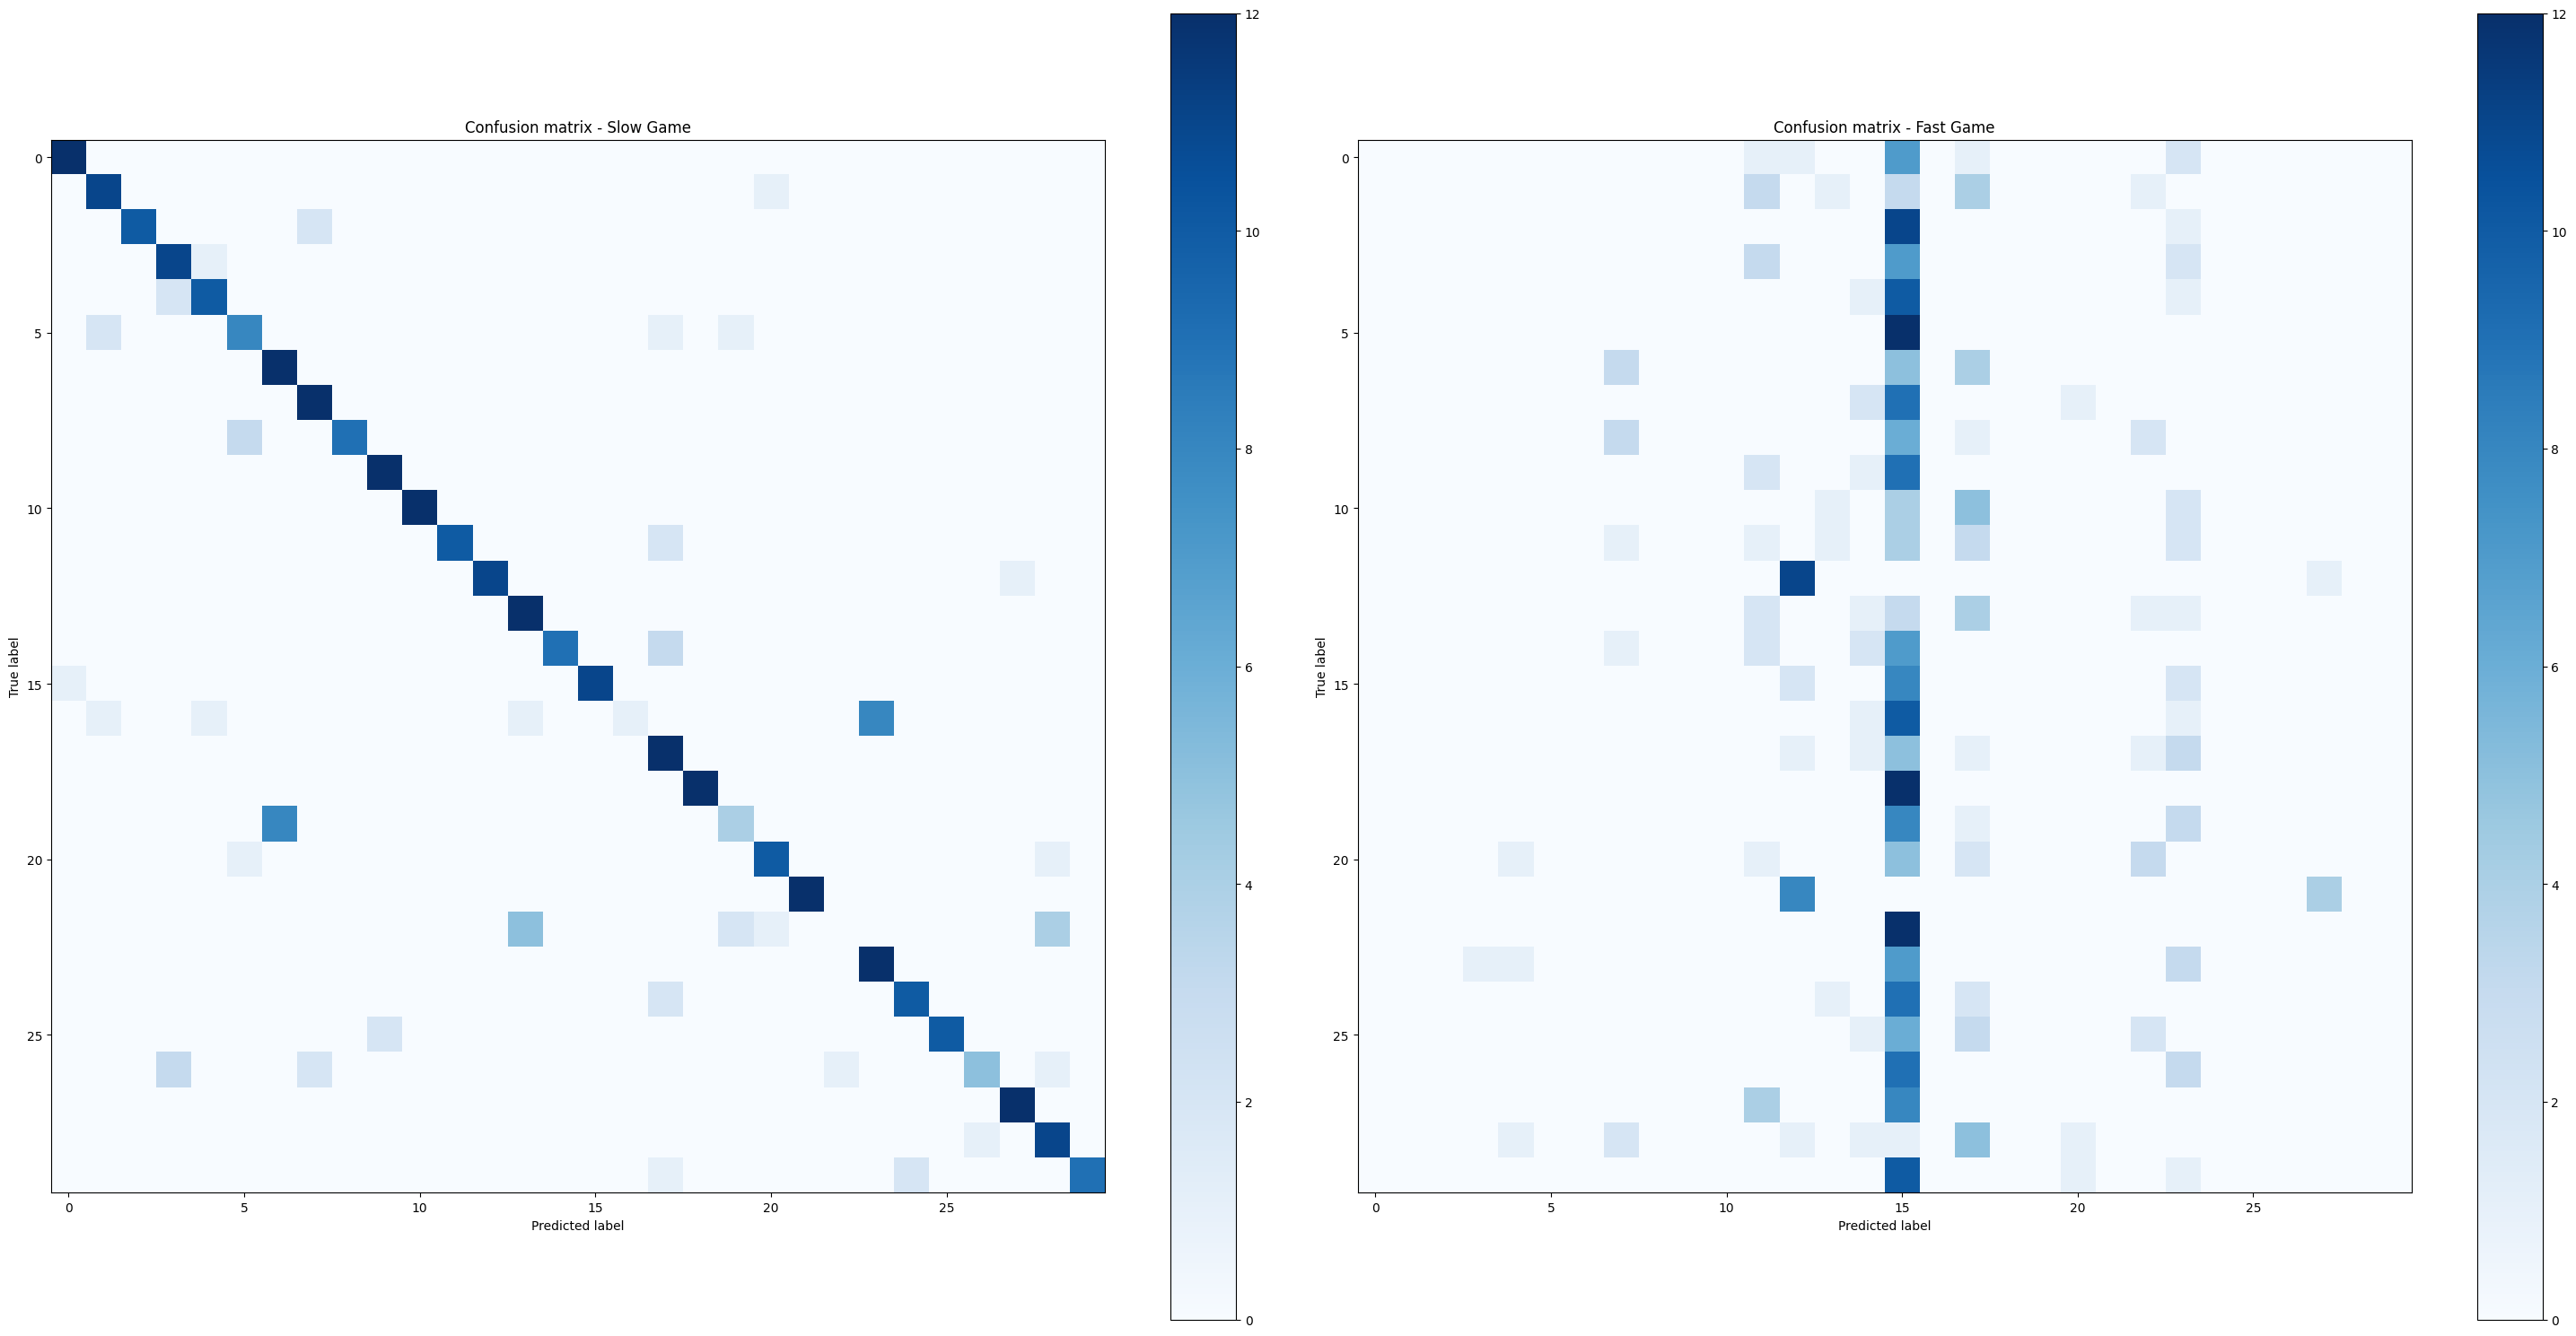

In [8]:
VisualizationUtils.confusion_matrices(cm_slow, cm_fast)

In [9]:
# Find the participant with the highest misclassification
misclassified_participant = np.argmax(np.sum(cm_slow, axis=1) - np.diag(cm_slow))
confused_with = np.argmax(cm_slow[misclassified_participant, :])
print(f"Participant {misclassified_participant} is most often misclassified as {confused_with}")

Participant 22 is most often misclassified as 13


In [10]:
# Compare features between the misclassified participant and the one they're confused with
features_to_compare = [col for col in mov_slow.columns if col != 'ID']
misclassified_data = mov_slow[mov_slow['ID'] == misclassified_participant][features_to_compare]
confused_with_data = mov_slow[mov_slow['ID'] == confused_with][features_to_compare]

In [11]:
# Calculate feature similarities
similarities = 1 - np.abs(misclassified_data.mean() - confused_with_data.mean()) / (misclassified_data.mean() + confused_with_data.mean())

# Sort features by similarity
most_similar_features = similarities.sort_values(ascending=False)

In [12]:
print("\nTop 10 most similar features:")
print(most_similar_features.head(10))


Top 10 most similar features:
time_interval                  1.000000
Head_OrientationAccelY_mean    1.000000
Accel_HeadPosX_mean            1.000000
Accel_LeftTouchPosX_mean       0.999999
Accel_HeadPosX_min             0.999999
Head_OrientationAccelZ_mean    0.999997
Head_OrientationAccelX_mean    0.999997
Accel_LeftTouchPosZ_mean       0.999996
Accel_HeadPosZ_min             0.999996
Accel_RightTouchPosX_mean      0.999993
dtype: float64


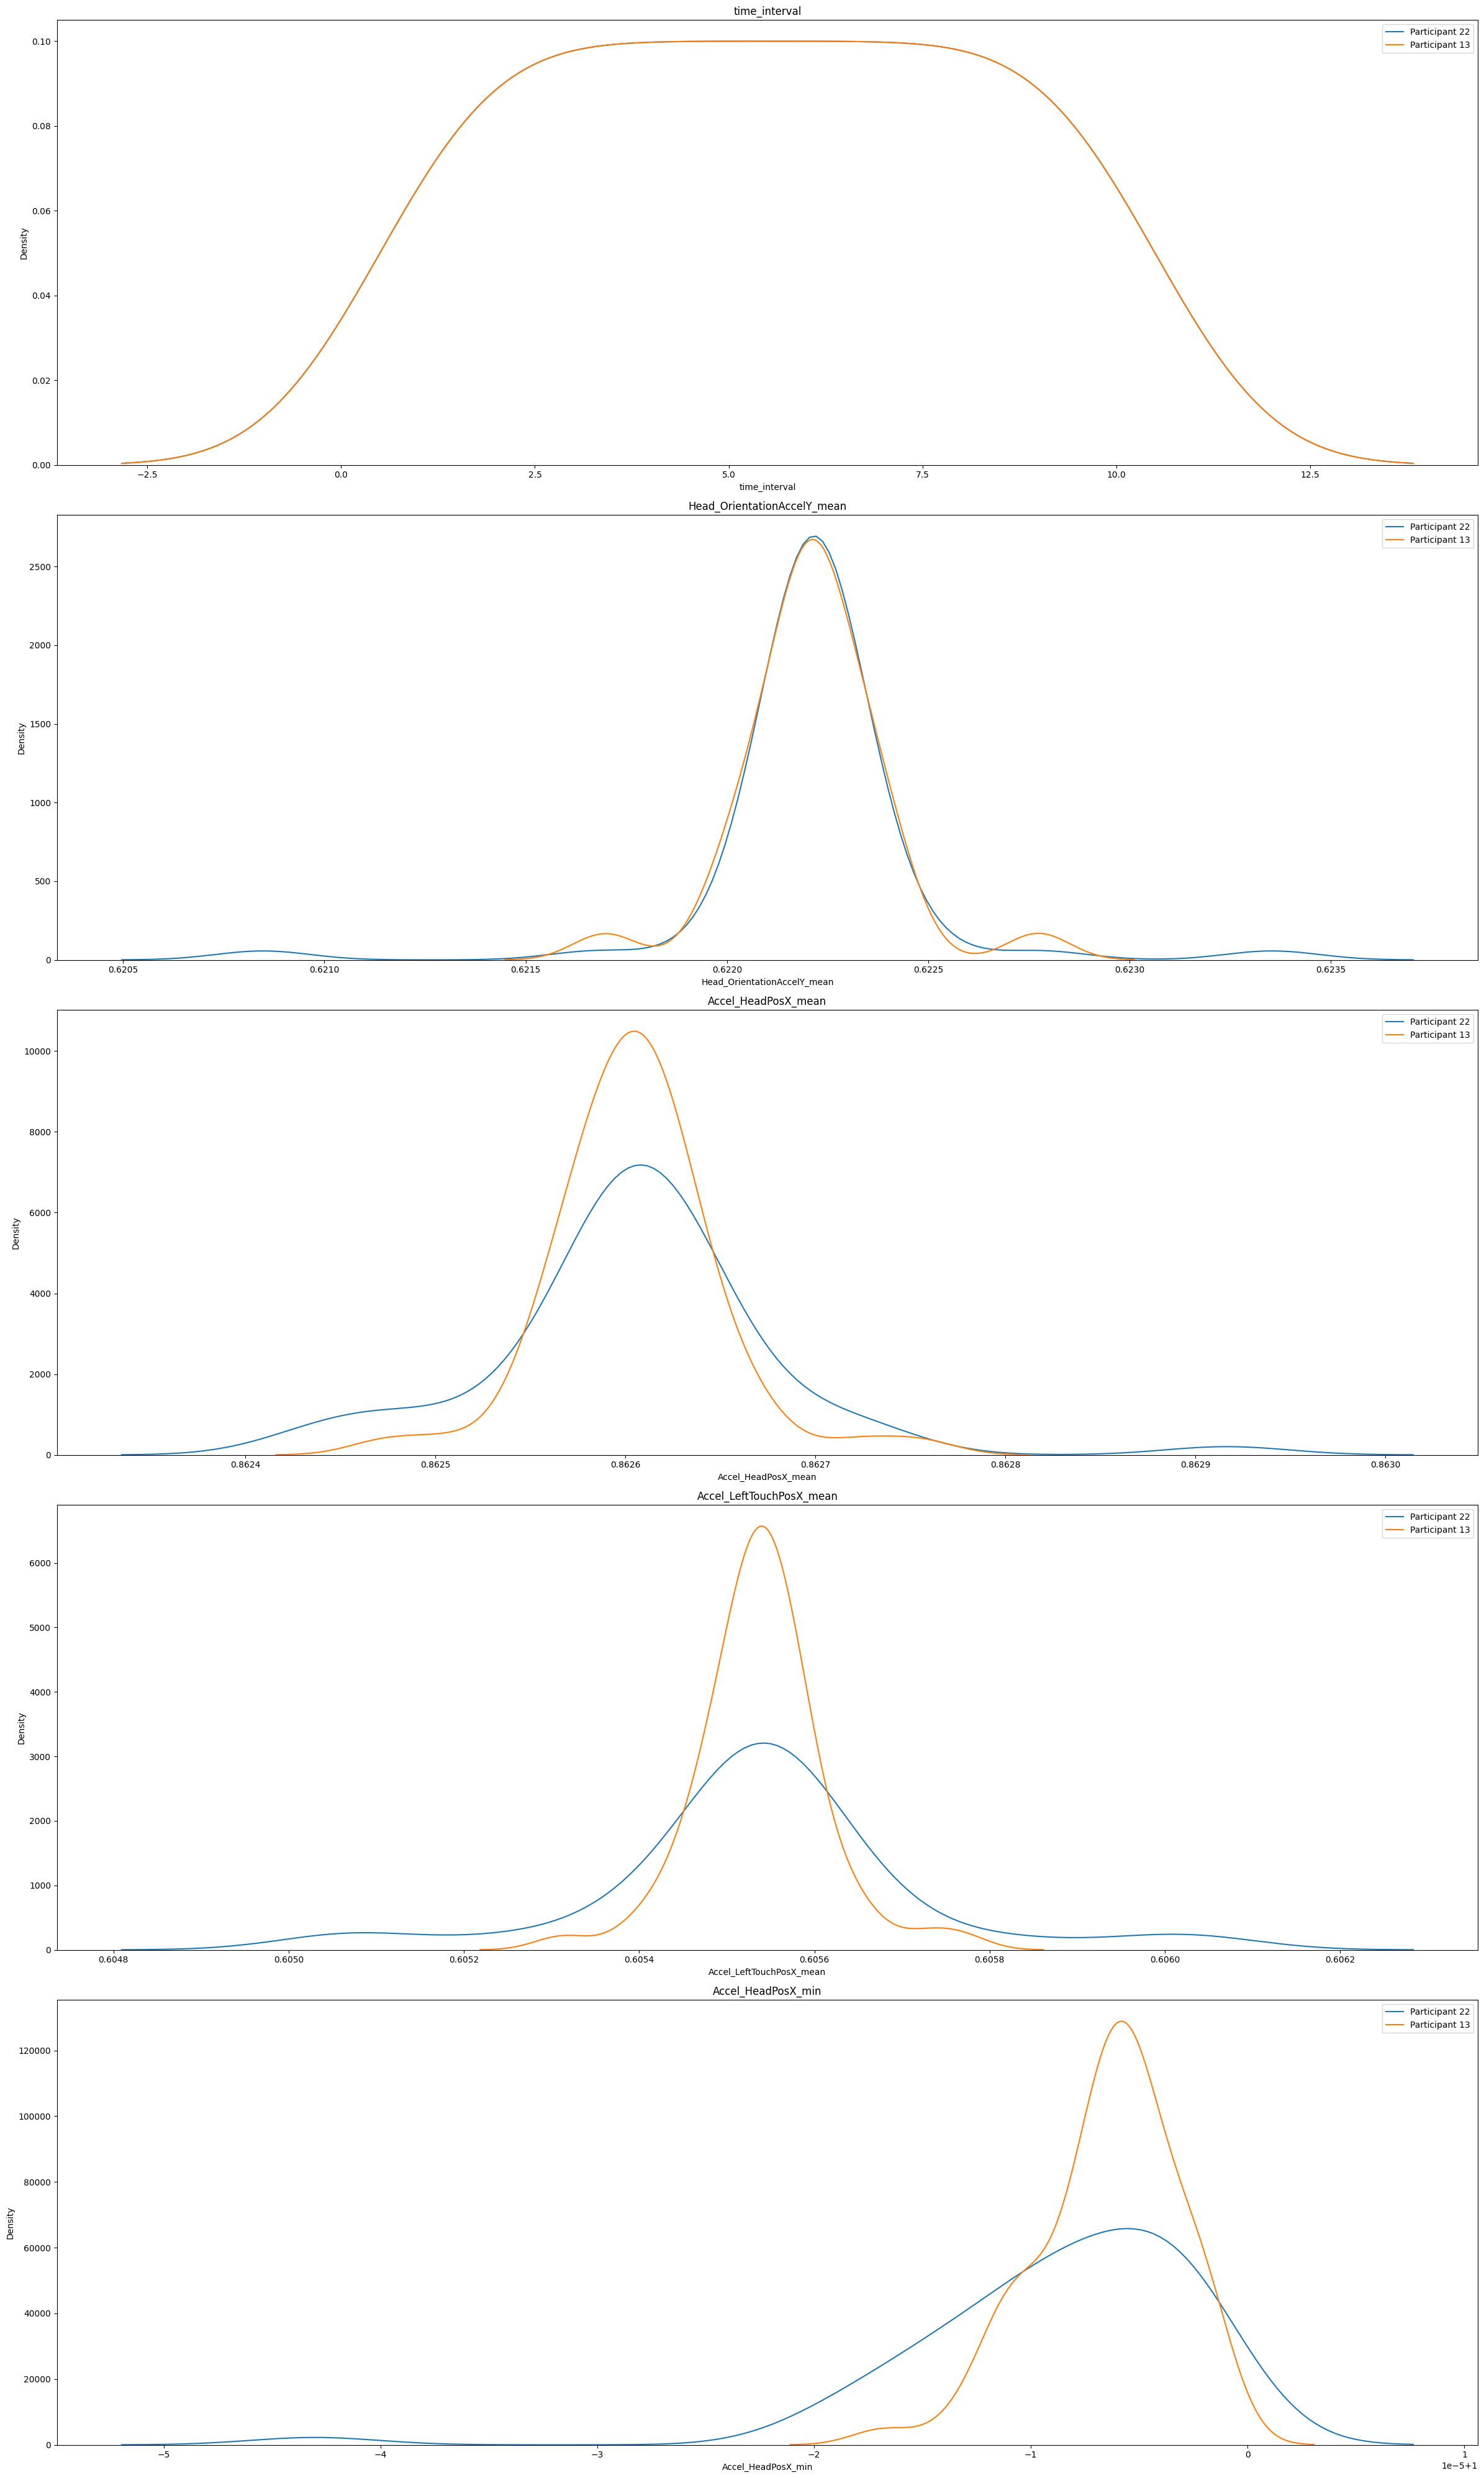

In [13]:
# Visualize feature distributions for top 5 similar features
top_5_features = most_similar_features.head(5).index

fig, axes = plt.subplots(5, 1, figsize=(24, 40))
for i, feature in enumerate(top_5_features):
    sns.kdeplot(data=misclassified_data[feature], ax=axes[i], label=f"Participant {misclassified_participant}")
    sns.kdeplot(data=confused_with_data[feature], ax=axes[i], label=f"Participant {confused_with}")
    axes[i].set_title(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [14]:
# Analyze differences in other features
differences = np.abs(misclassified_data.mean() - confused_with_data.mean()) / (misclassified_data.mean() + confused_with_data.mean())
most_different_features = differences.sort_values(ascending=False)

print("\nTop 10 most different features:")
print(most_different_features.head(10))


Top 10 most different features:
HeadOrientationW_min                0.939602
HeadOrientationW_25%                0.902683
HeadOrientationW_50%                0.872007
LeftTouch_OrientationAccelY_max     0.867718
HeadOrientationW_mean               0.863951
HeadOrientationW_75%                0.840295
LeftTouch_OrientationAccelX_max     0.829309
RightTouch_OrientationAccelX_max    0.790159
HeadOrientationW_max                0.763230
LeftTouch_OrientationAccelZ_max     0.754753
dtype: float64


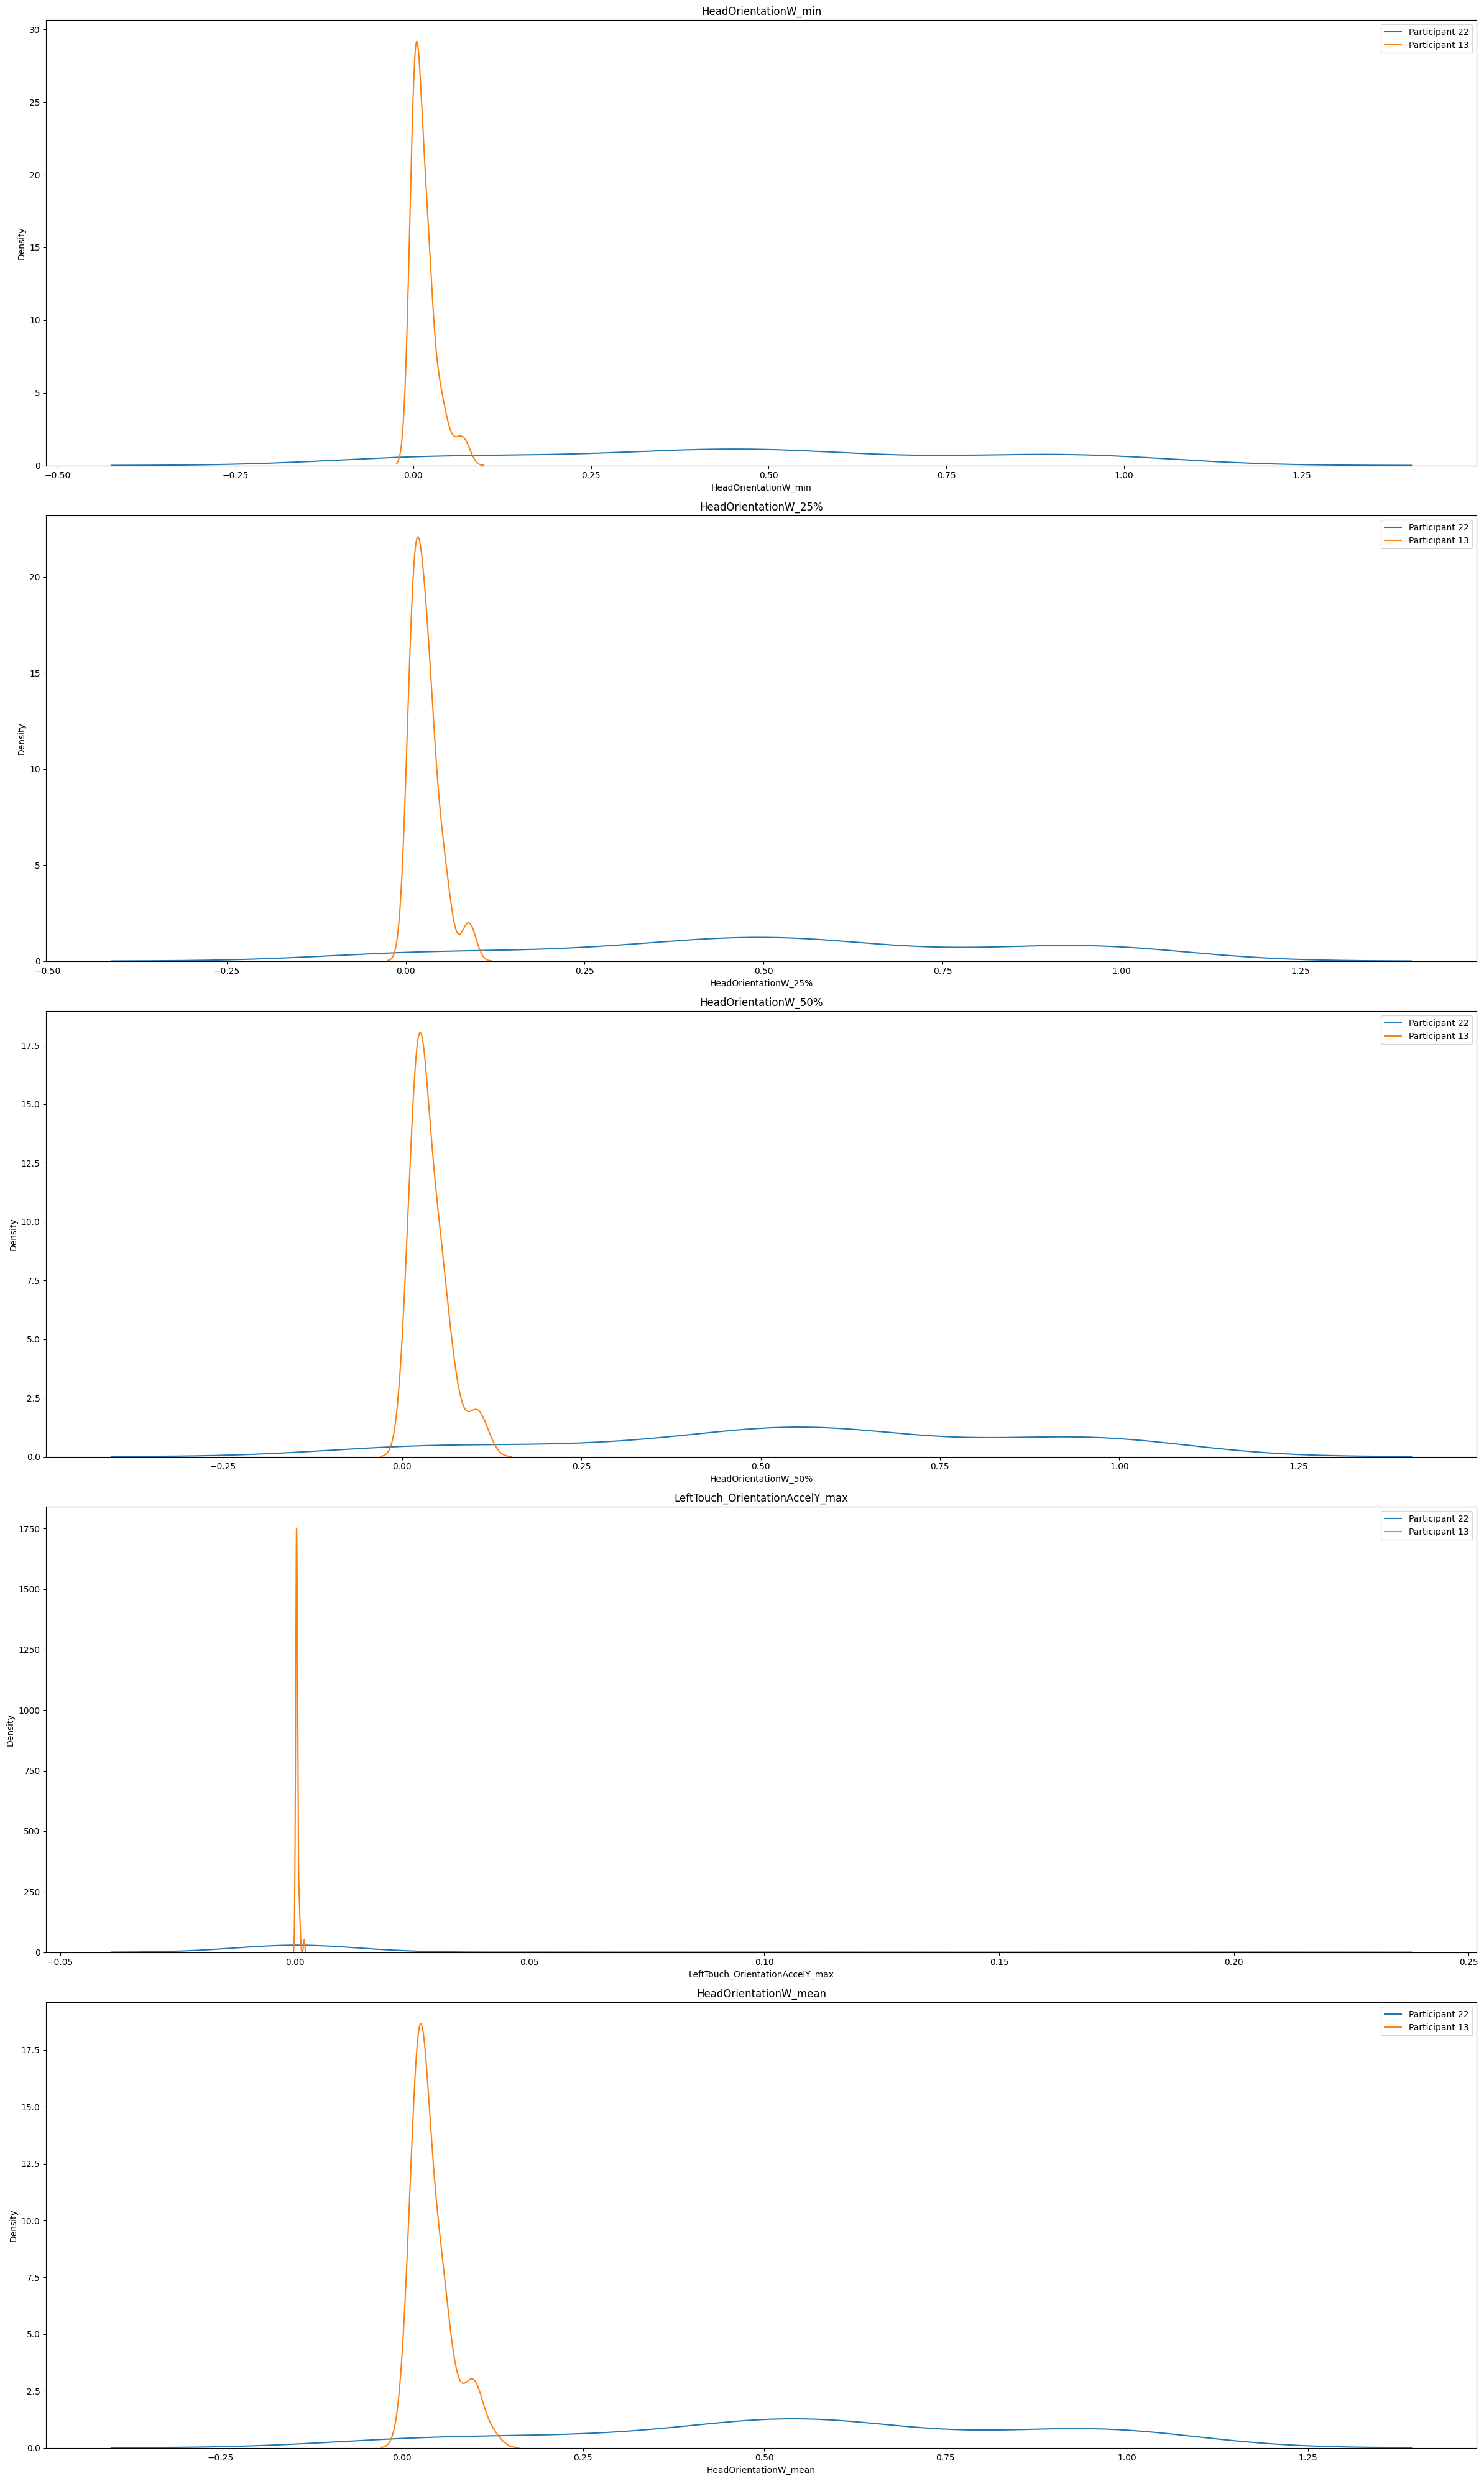

In [15]:
# Visualize feature distributions for top 5 different features
top_5_different_features = most_different_features.head(5).index

fig, axes = plt.subplots(5, 1, figsize=(24, 40))
for i, feature in enumerate(top_5_different_features):
    sns.kdeplot(data=misclassified_data[feature], ax=axes[i], label=f"Participant {misclassified_participant}")
    sns.kdeplot(data=confused_with_data[feature], ax=axes[i], label=f"Participant {confused_with}")
    axes[i].set_title(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

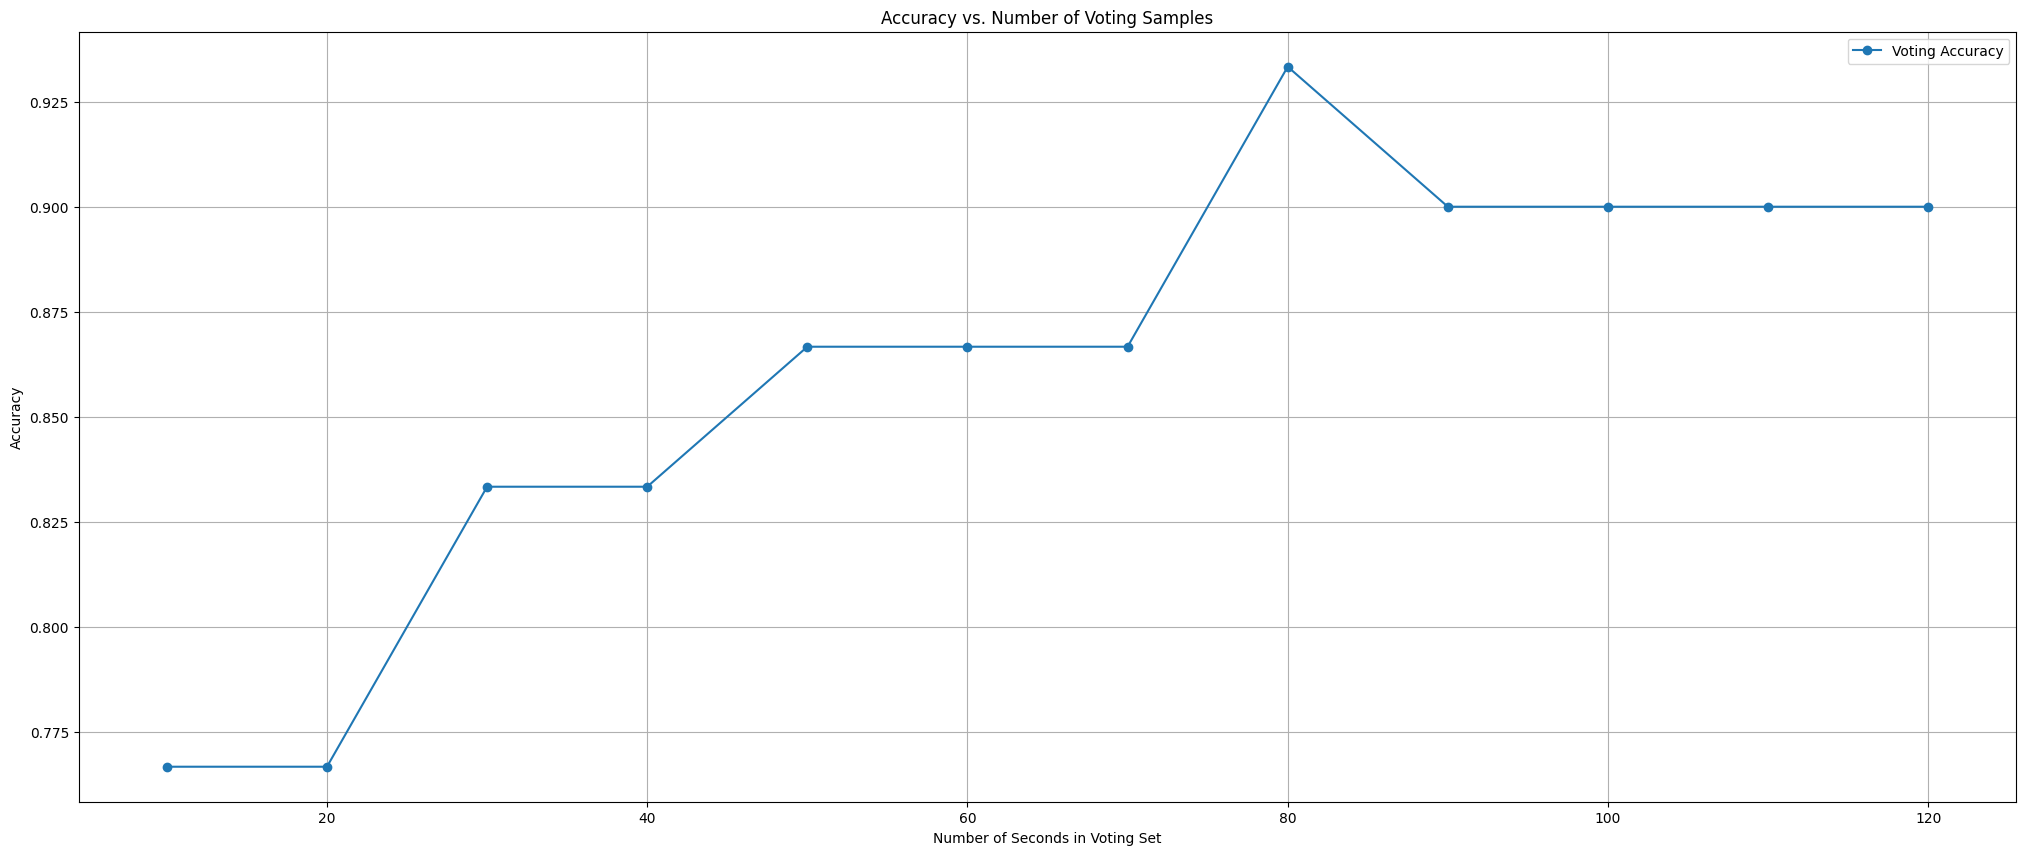


Vote Over Time Data Table:


,Seconds in Voting Set,Voting Accuracy
0,10,0.766667
1,20,0.766667
2,30,0.833333
3,40,0.833333
4,50,0.866667
5,60,0.866667
6,70,0.866667
7,80,0.933333
8,90,0.900000
9,100,0.900000


In [16]:
evaluator.plot_accuracy_by_vote(best_model_slow, X_test, y_test, increment=1)

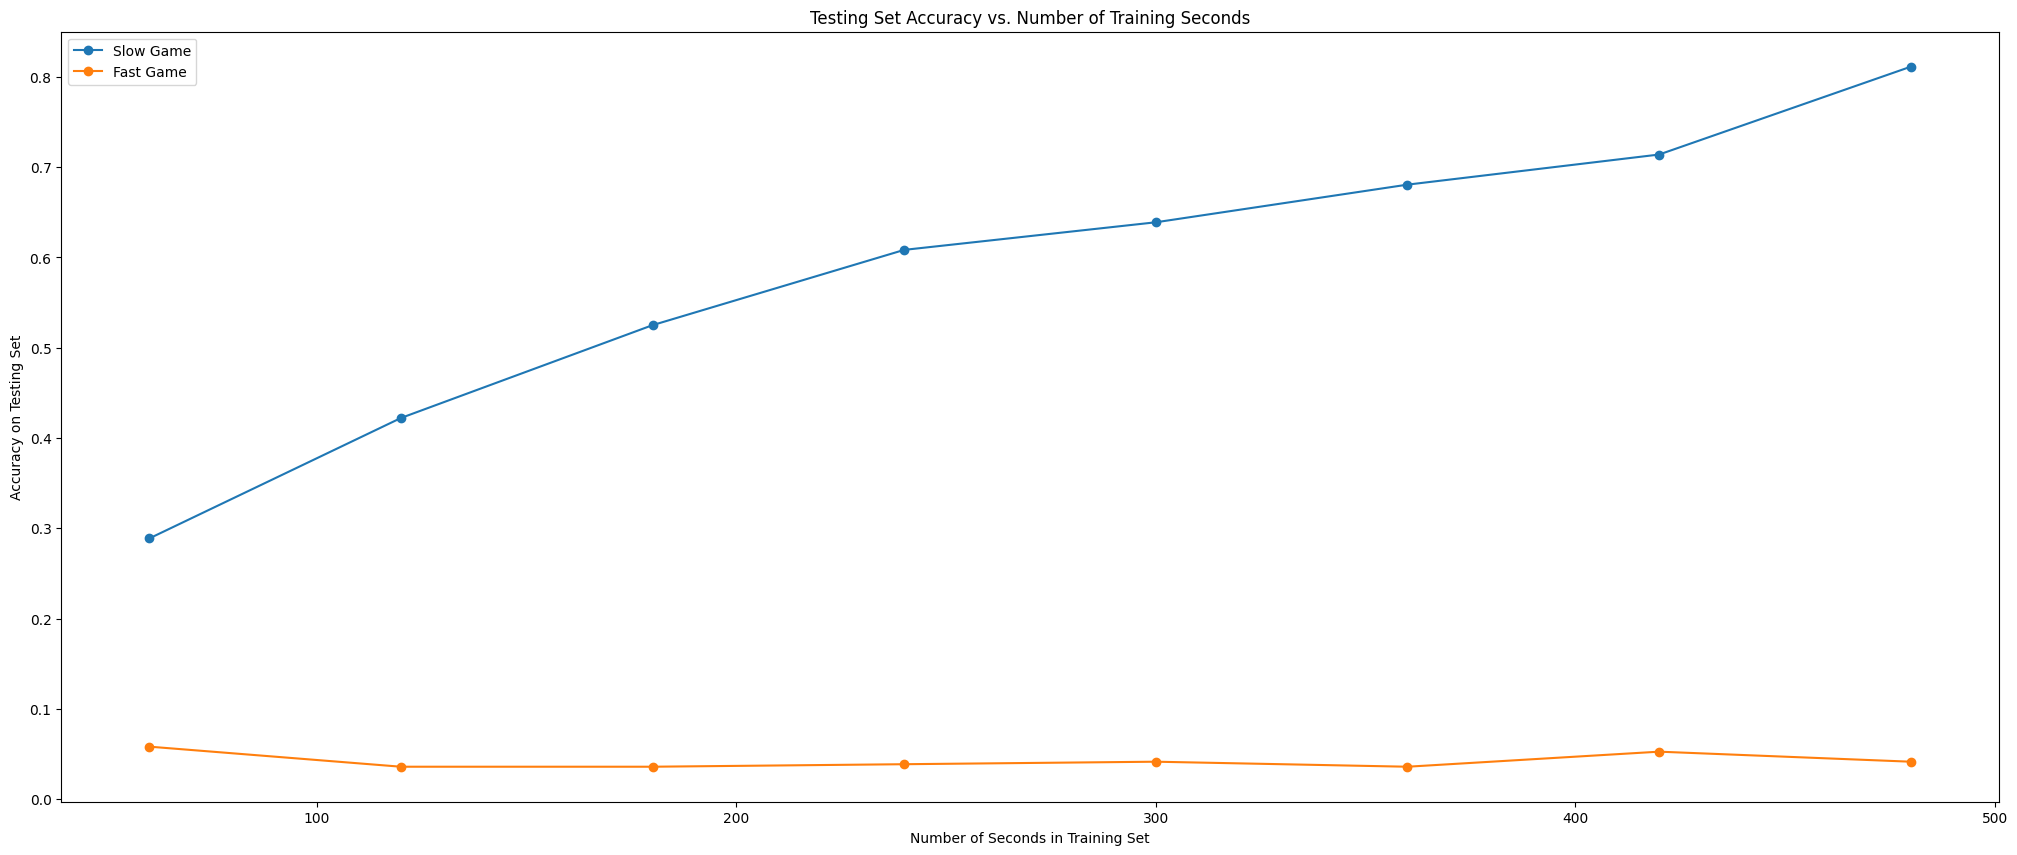


Accuracy Over Time Data Table:


,Seconds in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,60,0.288889,0.058333
1,120,0.422222,0.036111
2,180,0.525000,0.036111
3,240,0.608333,0.038889
4,300,0.638889,0.041667
5,360,0.680556,0.036111
6,420,0.713889,0.052778
7,480,0.811111,0.041667


In [17]:
evaluator.accuracy_over_time(X, y,best_model_slow_name, range(1,9), X_test, y_test, fX_test, fy_test)

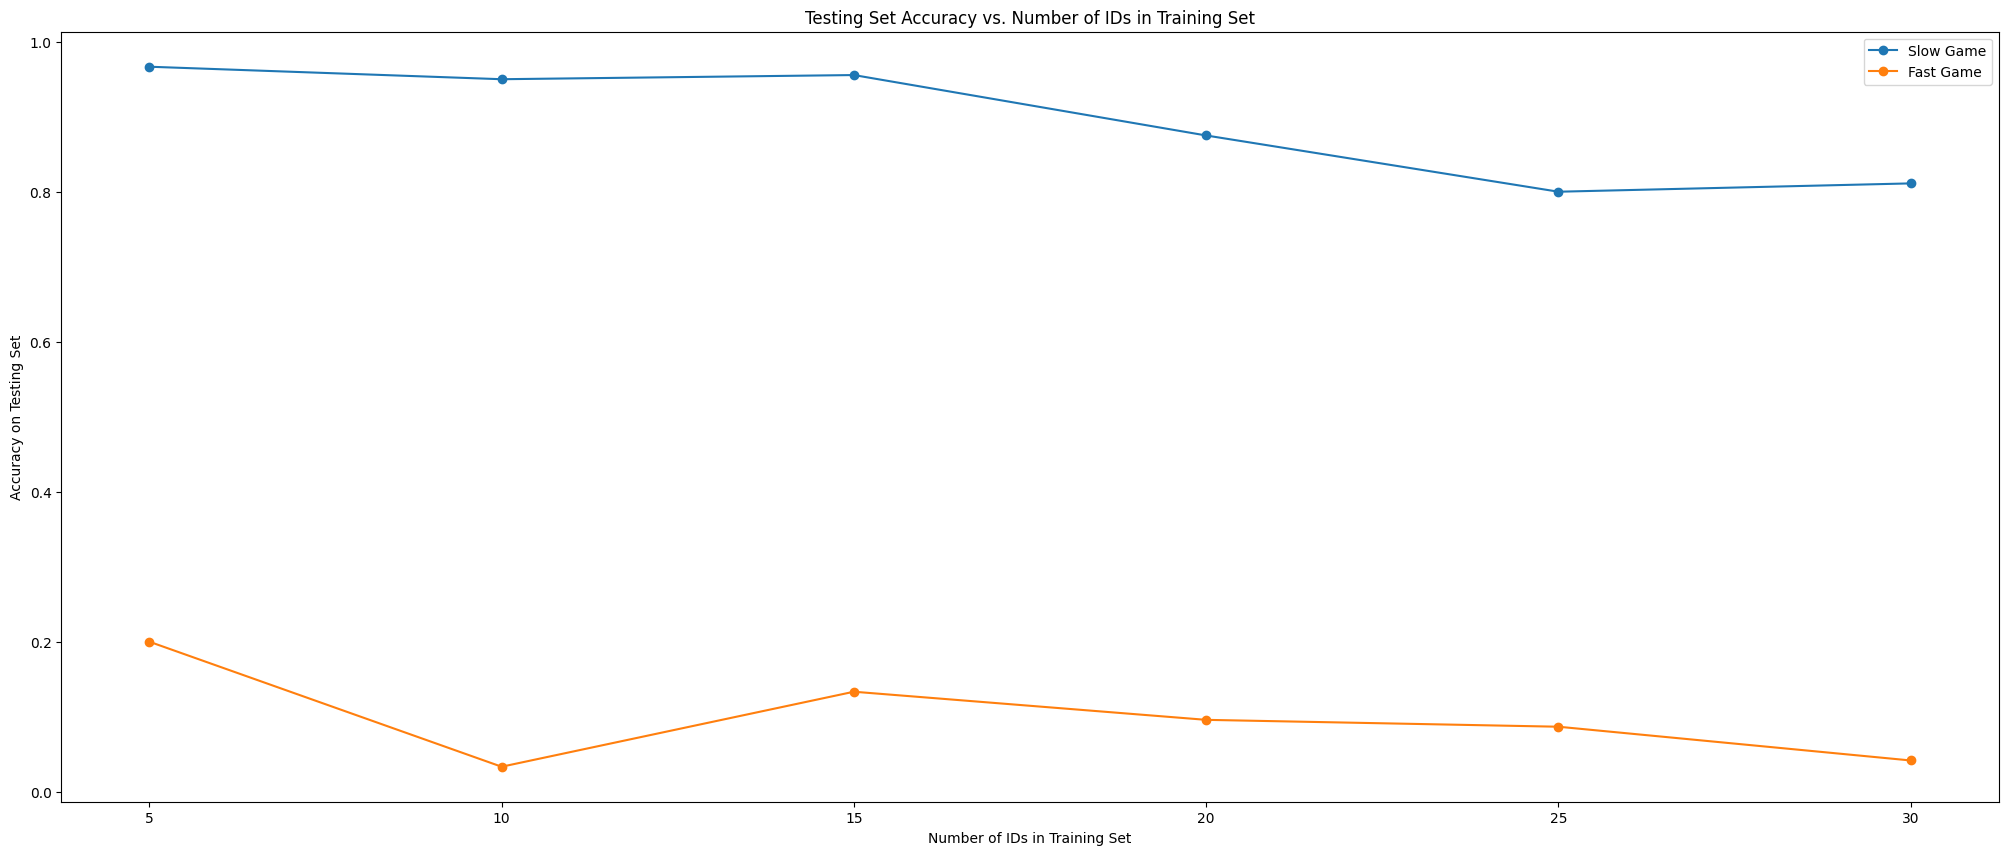


ID Over Time Data Table:


,Number of IDs in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,5,0.966667,0.200000
1,10,0.950000,0.033333
2,15,0.955556,0.133333
3,20,0.875000,0.095833
4,25,0.800000,0.086667
5,30,0.811111,0.041667


In [18]:
evaluator.accuracy_over_ids(X_train, y_train, best_model_slow_name,  X_test, y_test,fX_test, fy_test)

### 3.1.2. Training On Beat Saber

In [19]:
Accuracy_set, models, best_model_slow, best_model_fast, cm_slow, cm_fast,  best_model_slow_name, best_model_fast_name = evaluator.evaluate_classifiers(fX_train,fy_train,X_test,y_test,fX_test,fy_test)
Accuracy_set.sort_values(by='Accuracy(Fast)').style.background_gradient(cmap= plt.cm.Blues)

100%|██████████| 15/15 [06:32<00:00, 26.18s/it]


,Model,Accuracy(Train),Accuracy(Slow),Accuracy(Fast),F1(Train),F1(Slow),F1(Fast),Precision(Train),Precision(Slow),Precision(Fast),Recall(Train),Recall(Slow),Recall(Fast),Log_loss(Train),Log_loss(Slow),Log_loss(Fast)
9,QuadraticDiscriminantAnalysis,1.000000,0.033333,0.058333,1.000000,0.026642,0.058739,1.000000,0.023126,0.066334,1.000000,0.033333,0.058333,0.000000,34.842198,33.941107
7,AdaBoostClassifier,0.100000,0.061111,0.100000,0.057146,0.016874,0.057343,0.050053,0.011038,0.050572,0.100000,0.061111,0.100000,3.091688,4.151395,3.101868
11,BernoulliNB,0.225694,0.058333,0.225000,0.227429,0.018121,0.184227,0.403680,0.011918,0.176715,0.225694,0.058333,0.225000,2.743500,3.864866,2.997814
0,SVC,0.554861,0.041667,0.550000,0.547132,0.016897,0.521369,0.636855,0.011765,0.545249,0.554861,0.041667,0.550000,3.408419,3.401800,3.407212
8,GaussianNB,0.809722,0.097222,0.638889,0.797509,0.063526,0.627510,0.834468,0.069156,0.700523,0.809722,0.097222,0.638889,5.742456,32.413045,11.764650
4,KNeighborsClassifier,0.834028,0.022222,0.691667,0.833351,0.016001,0.679795,0.843981,0.013871,0.717509,0.834028,0.022222,0.691667,0.475049,33.338040,5.115330
3,DecisionTreeClassifier,1.000000,0.086111,0.741667,1.000000,0.078971,0.733570,1.000000,0.084625,0.751663,1.000000,0.086111,0.741667,0.000000,32.939894,9.311277
12,BaggingClassifier,0.997917,0.061111,0.847222,0.997923,0.057665,0.831711,0.997986,0.064785,0.862693,0.997917,0.061111,0.847222,0.125939,26.639557,1.075080
5,RandomForestClassifier,1.000000,0.050000,0.886111,1.000000,0.052650,0.883692,1.000000,0.098408,0.902768,1.000000,0.050000,0.886111,0.146466,11.496360,0.672488
10,LogisticRegression,0.989583,0.033333,0.894444,0.989541,0.018804,0.893036,0.989904,0.017330,0.909082,0.989583,0.033333,0.894444,0.262884,6.309355,0.535787


In [20]:
explainer = shap.TreeExplainer(best_model_fast)
shap_values_fast = explainer.shap_values(fX_test)

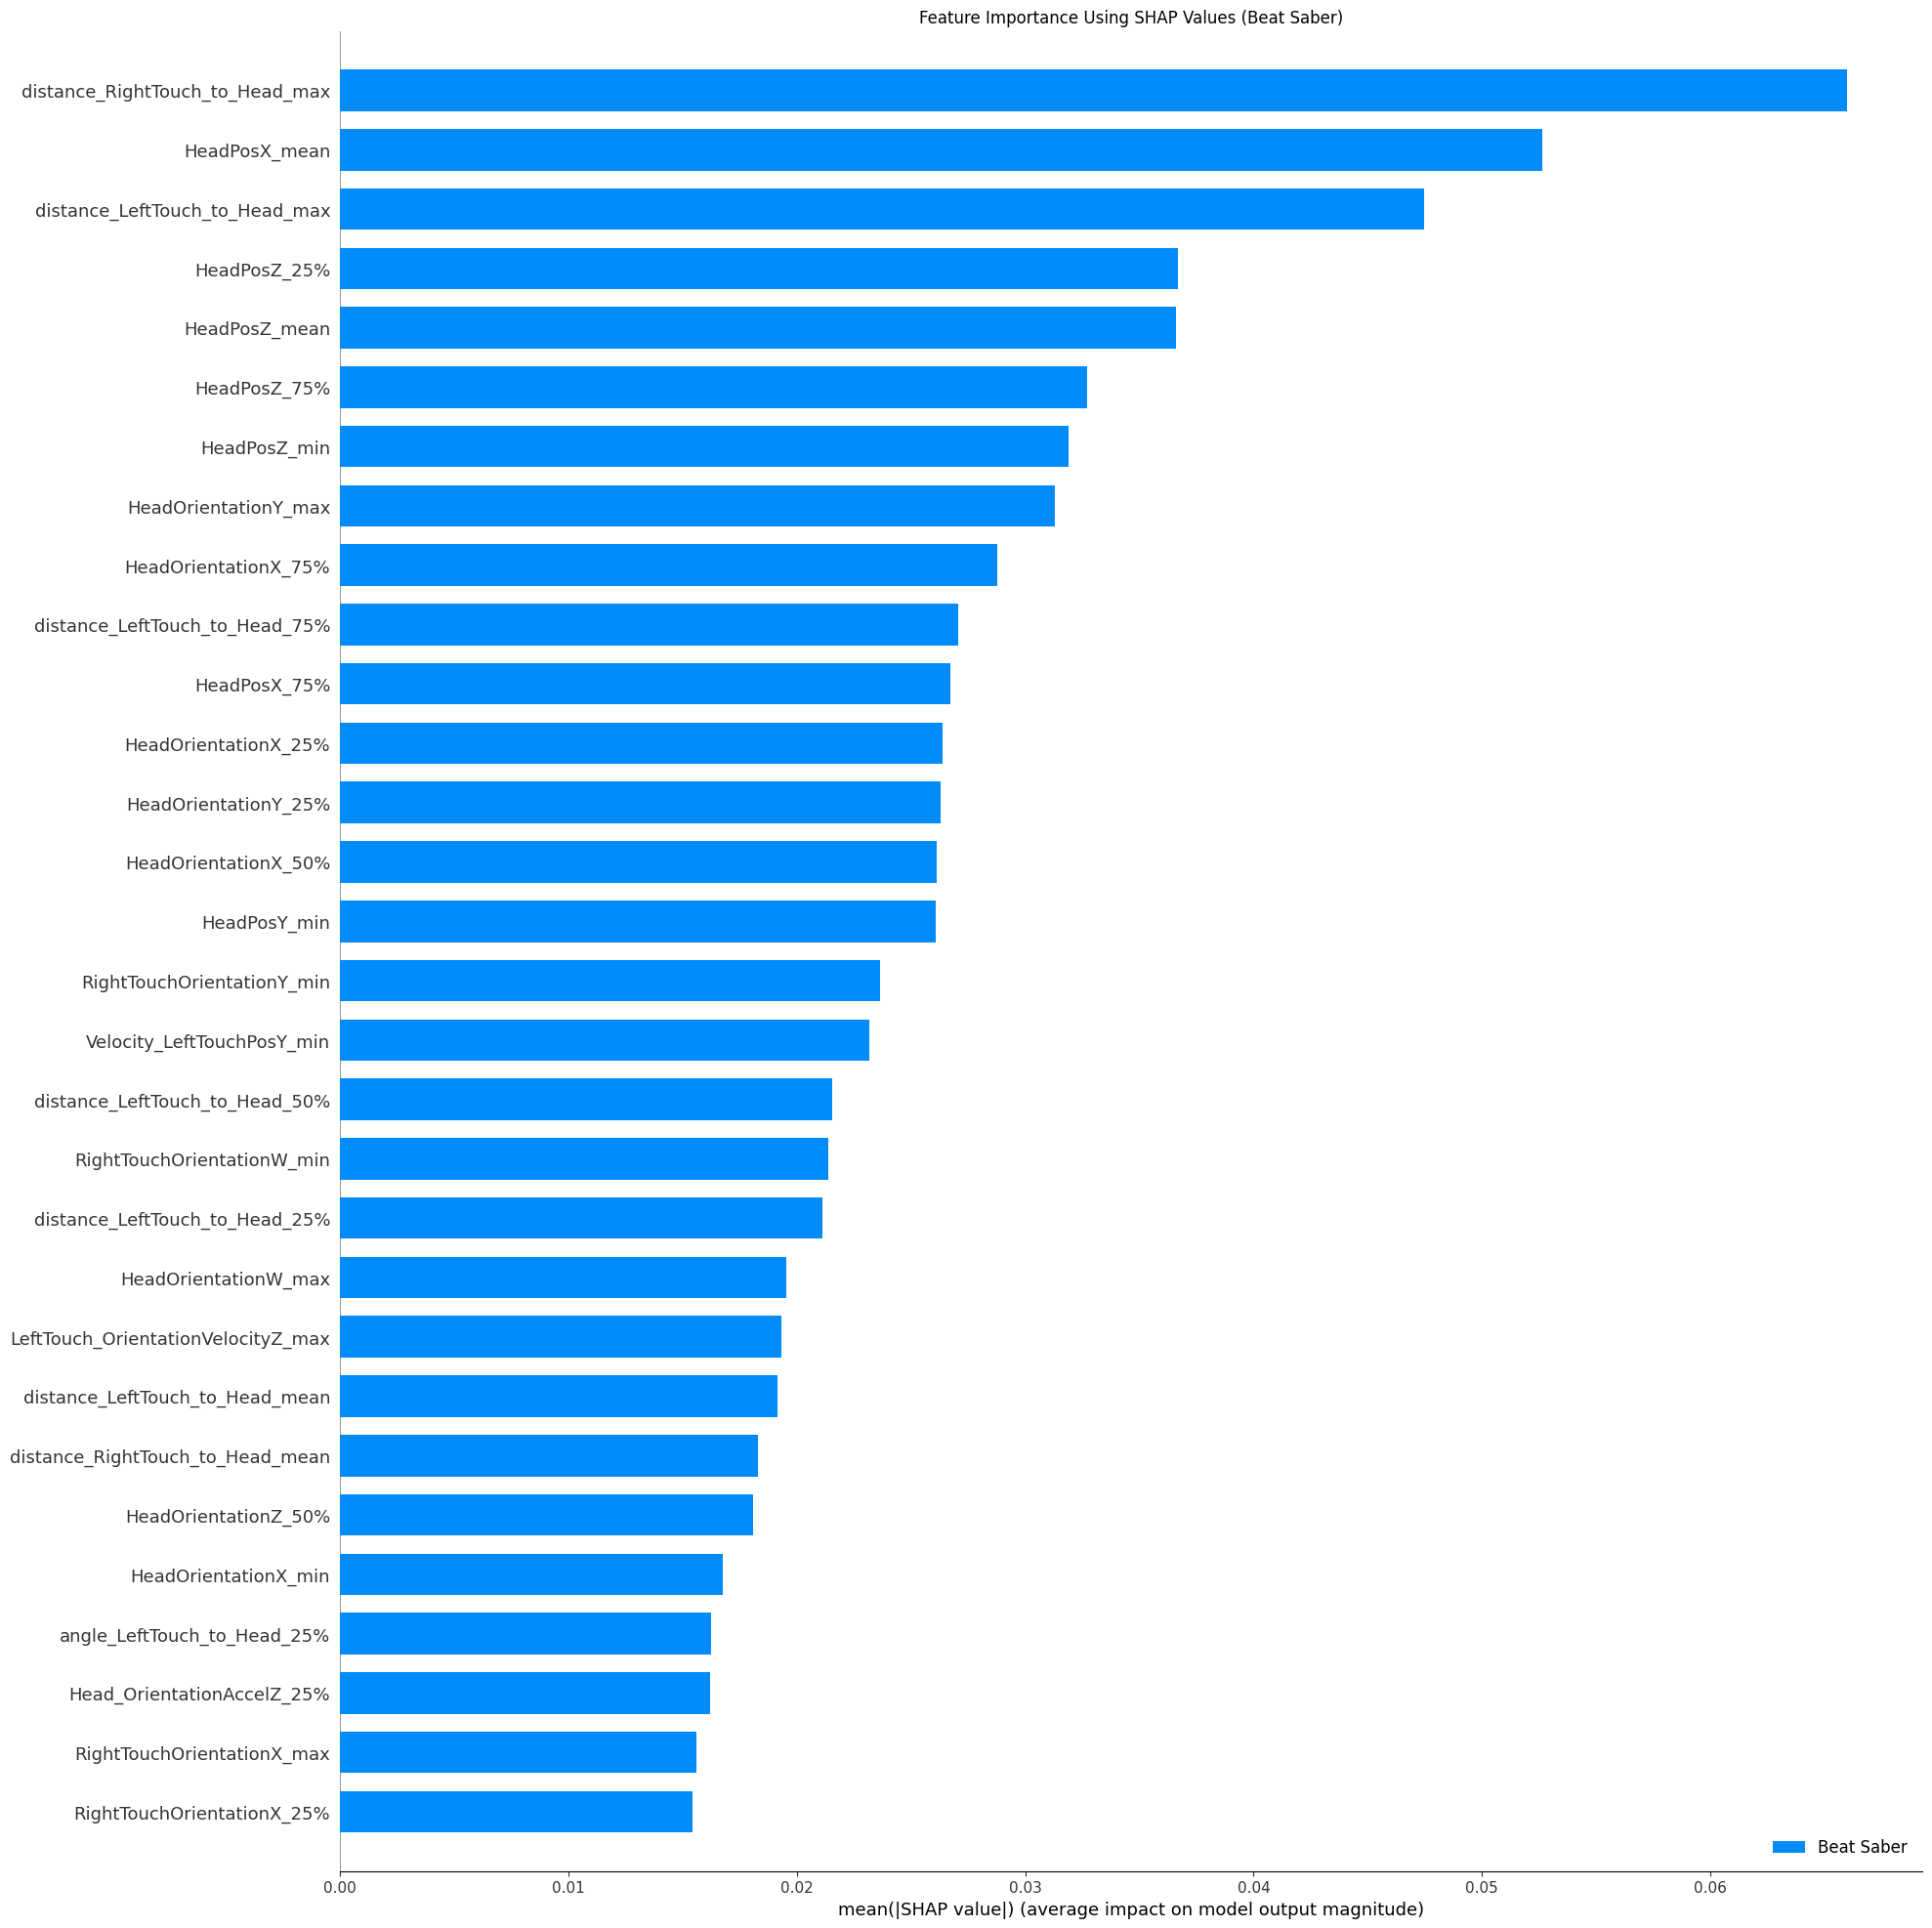

In [21]:
VisualizationUtils.shap_plotter([np.mean(shap_values_fast, axis=2)], 
                          fX_test, title="Feature Importance Using SHAP Values (Beat Saber)",
                          class_names=['Beat Saber'])

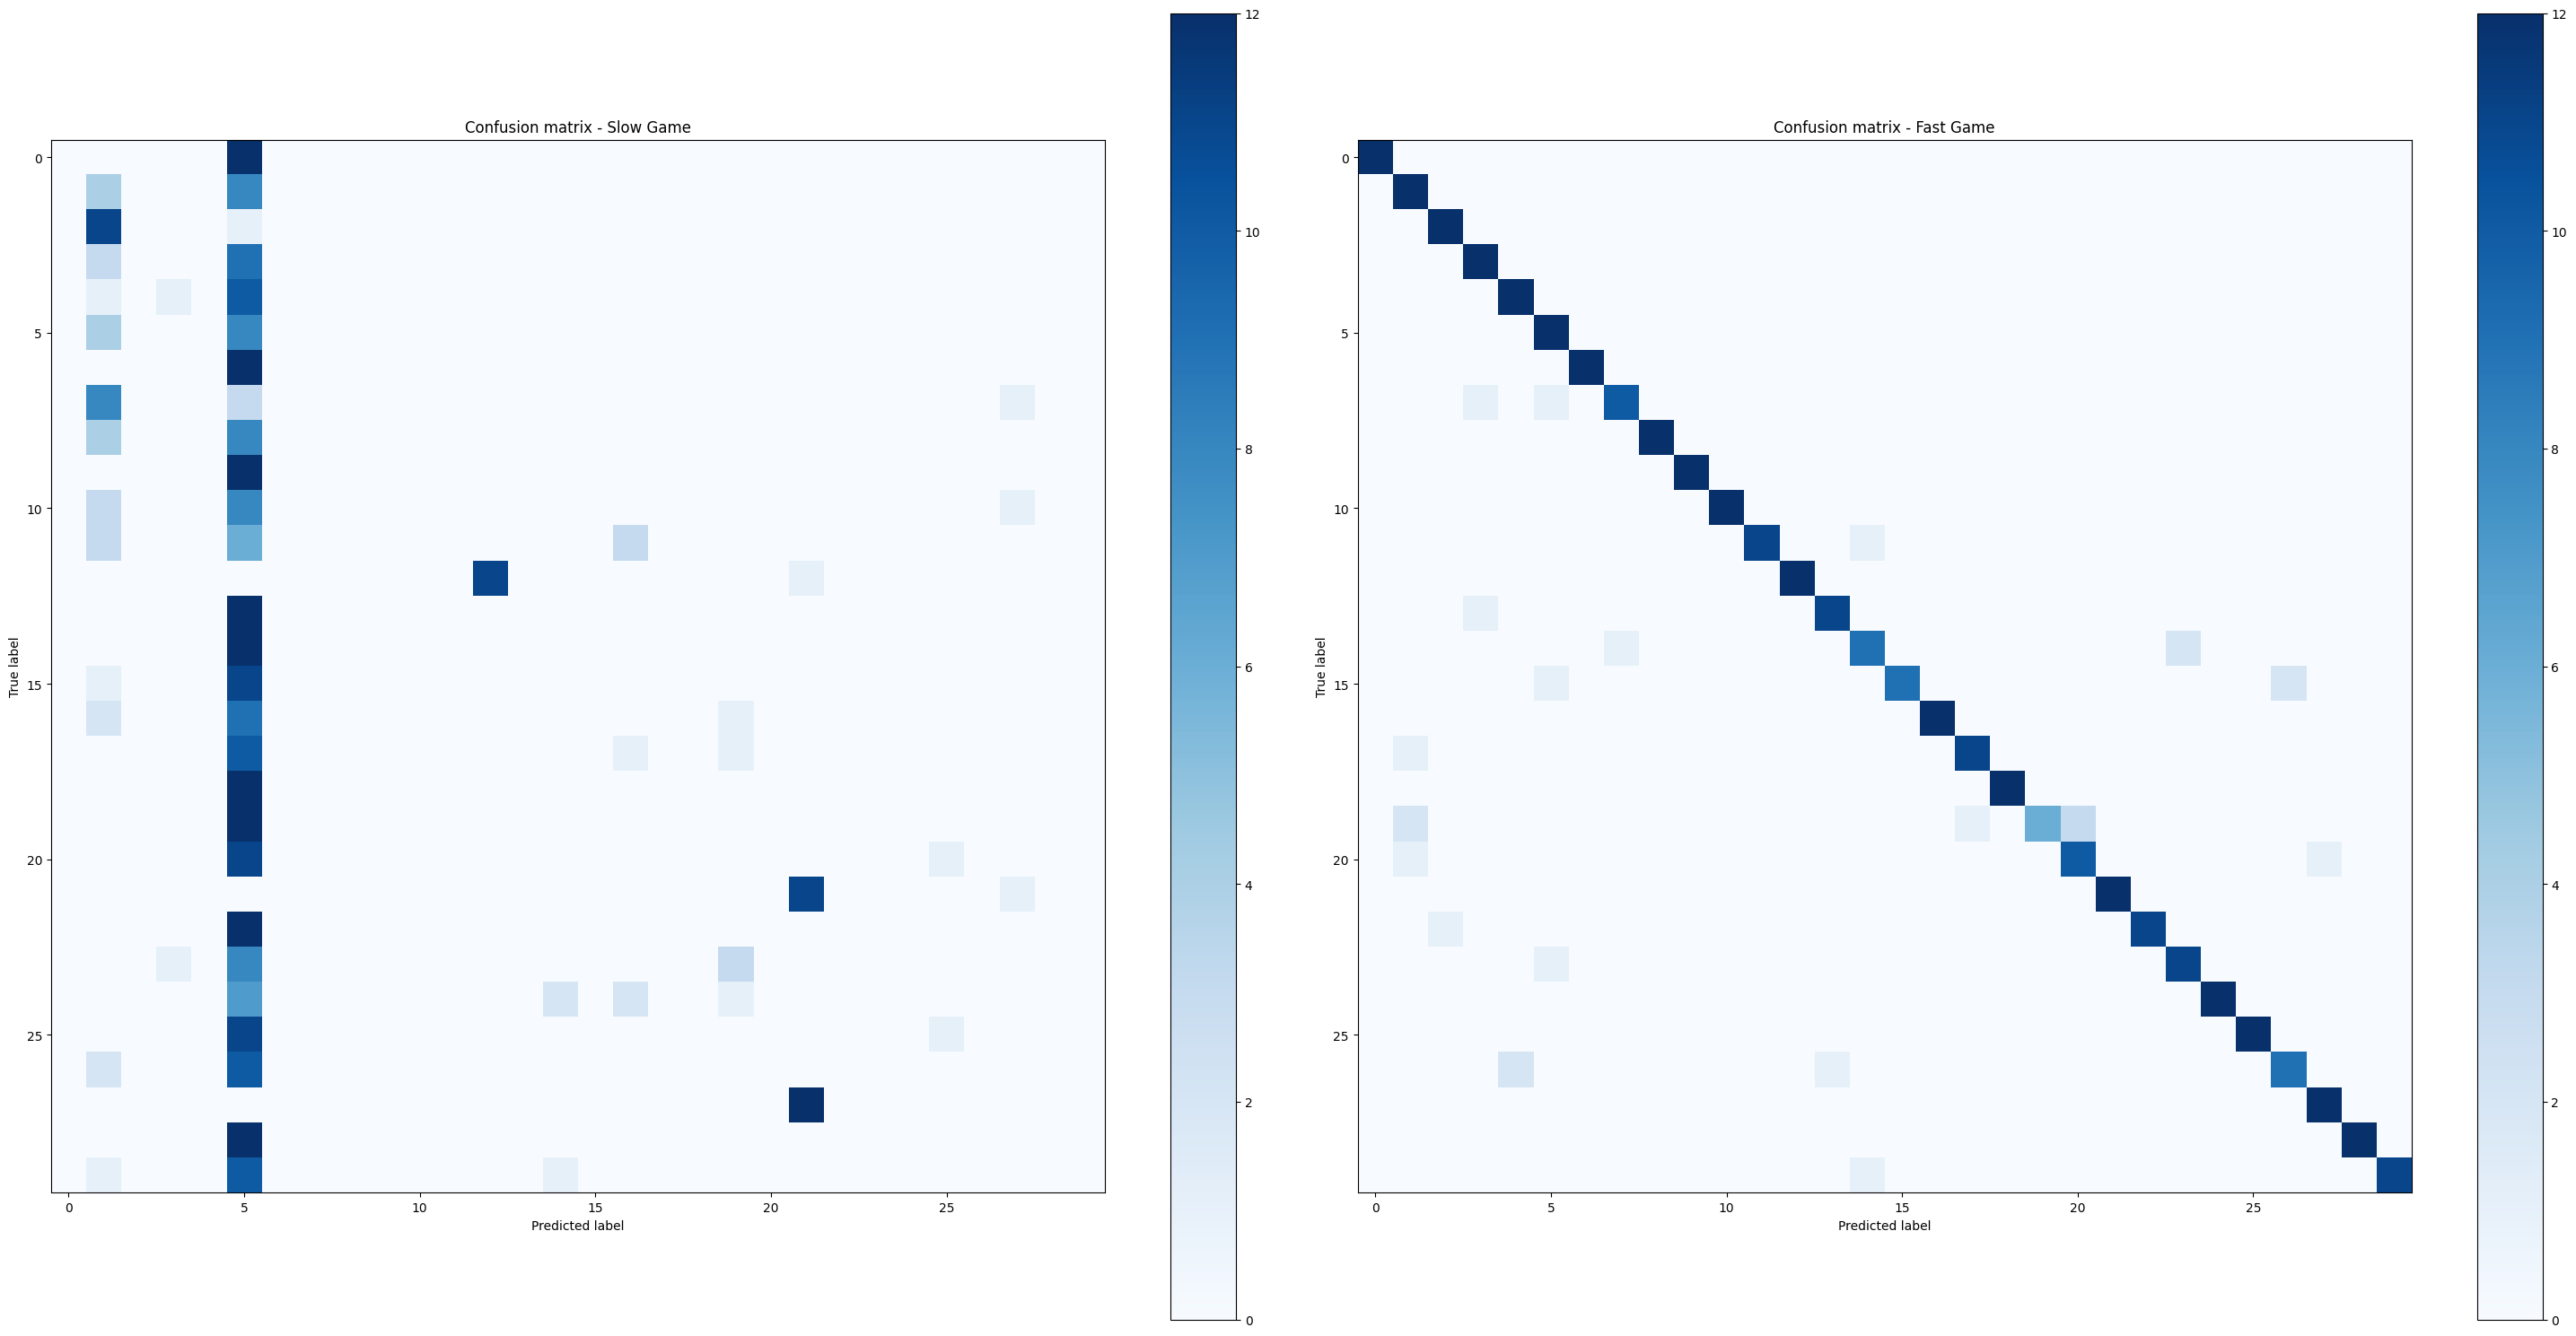

In [22]:
VisualizationUtils.confusion_matrices(cm_slow, cm_fast)

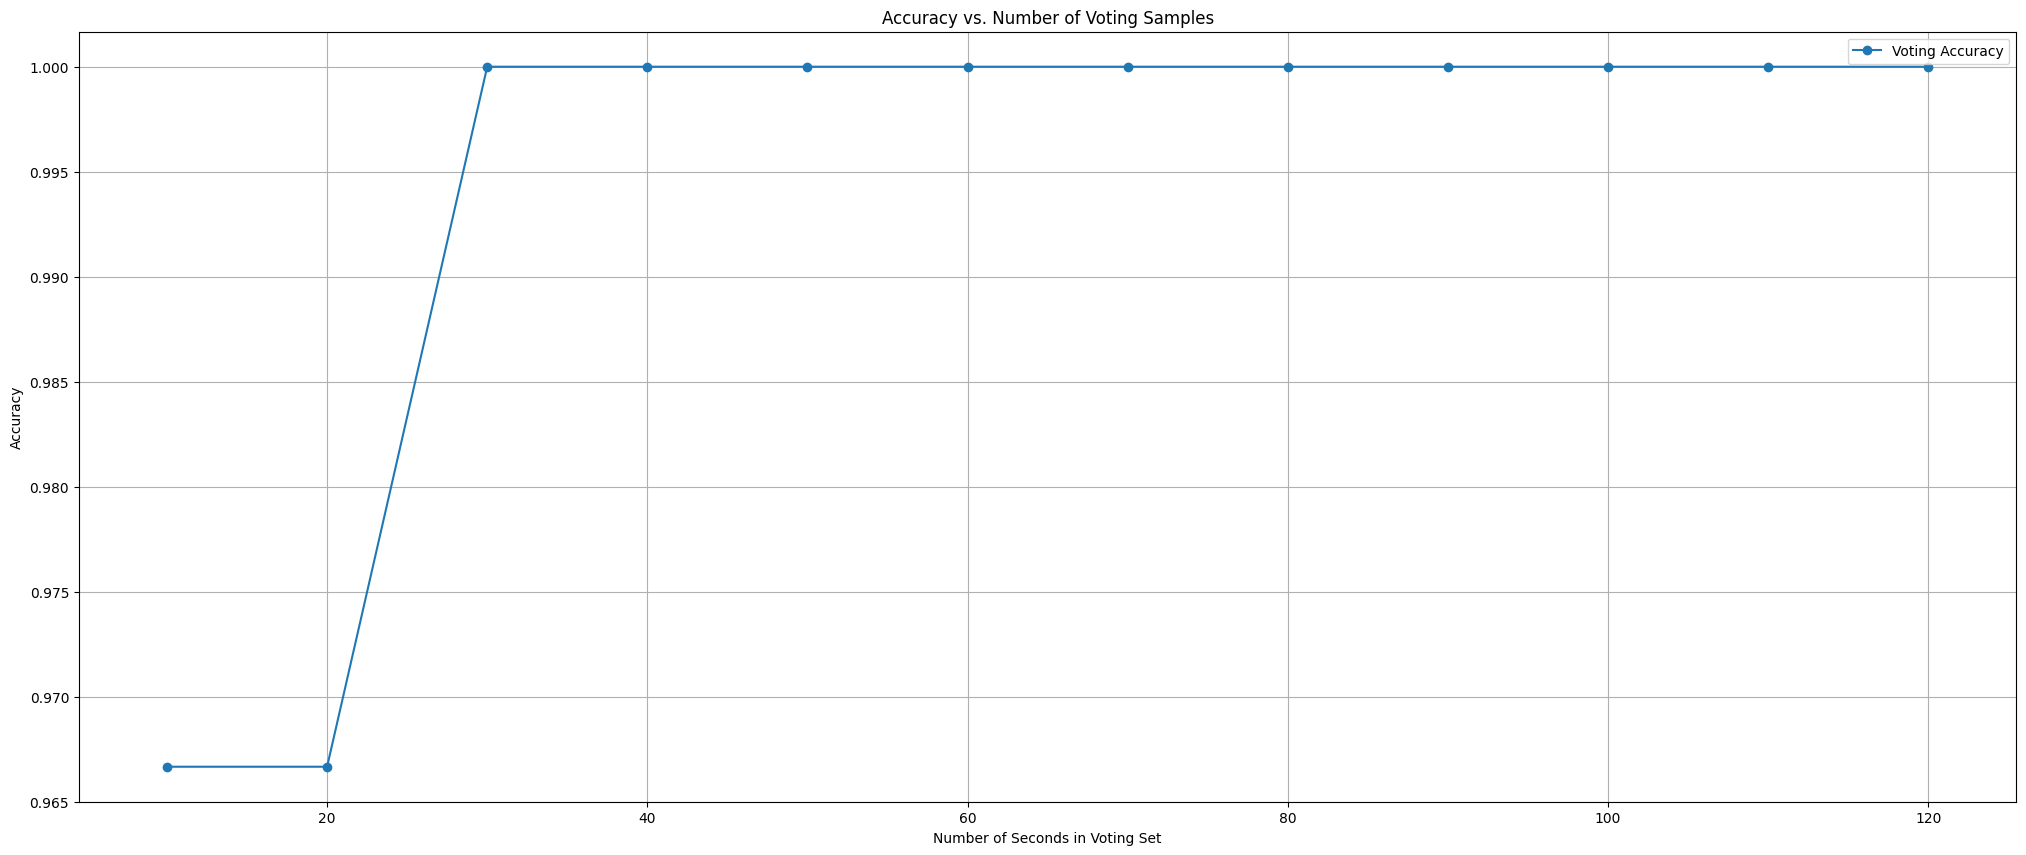


Vote Over Time Data Table:


,Seconds in Voting Set,Voting Accuracy
0,10,0.966667
1,20,0.966667
2,30,1.000000
3,40,1.000000
4,50,1.000000
5,60,1.000000
6,70,1.000000
7,80,1.000000
8,90,1.000000
9,100,1.000000


In [23]:
evaluator.plot_accuracy_by_vote(best_model_fast, fX_test, fy_test, increment=1)

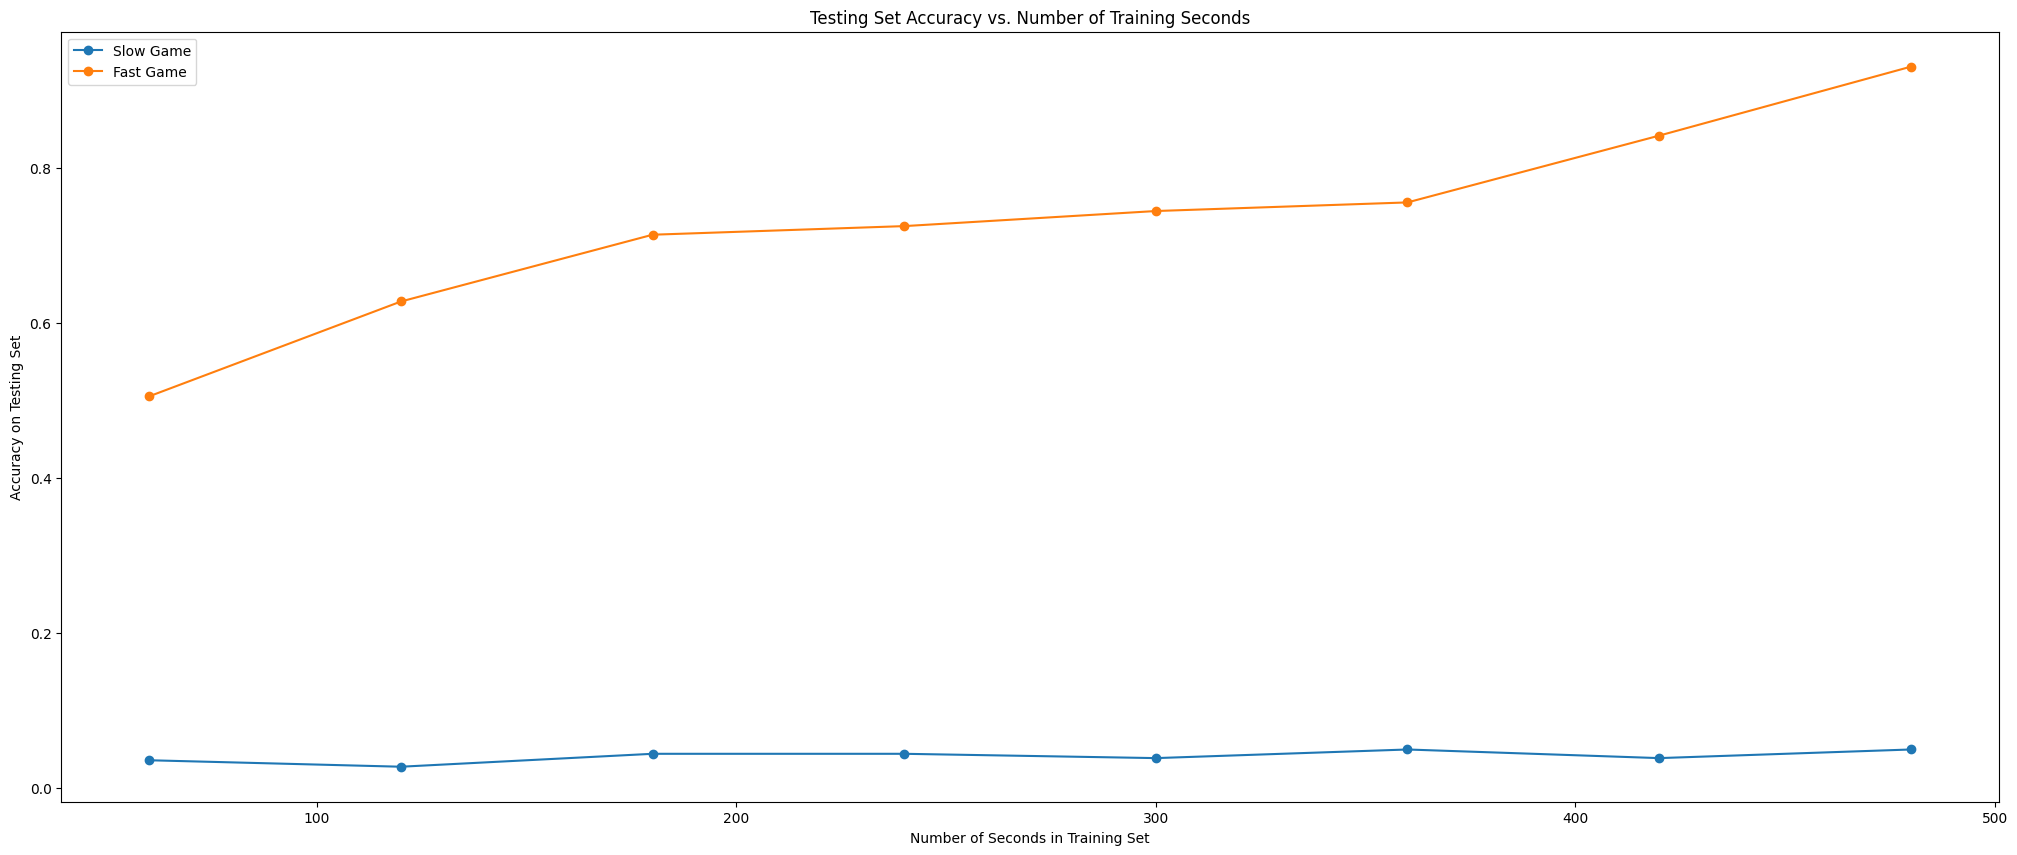


Accuracy Over Time Data Table:


,Seconds in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,60,0.036111,0.505556
1,120,0.027778,0.627778
2,180,0.044444,0.713889
3,240,0.044444,0.725000
4,300,0.038889,0.744444
5,360,0.050000,0.755556
6,420,0.038889,0.841667
7,480,0.050000,0.930556


In [24]:
evaluator.accuracy_over_time(fX, fy, best_model_fast_name, range(1,9), X_test, y_test, fX_test, fy_test)

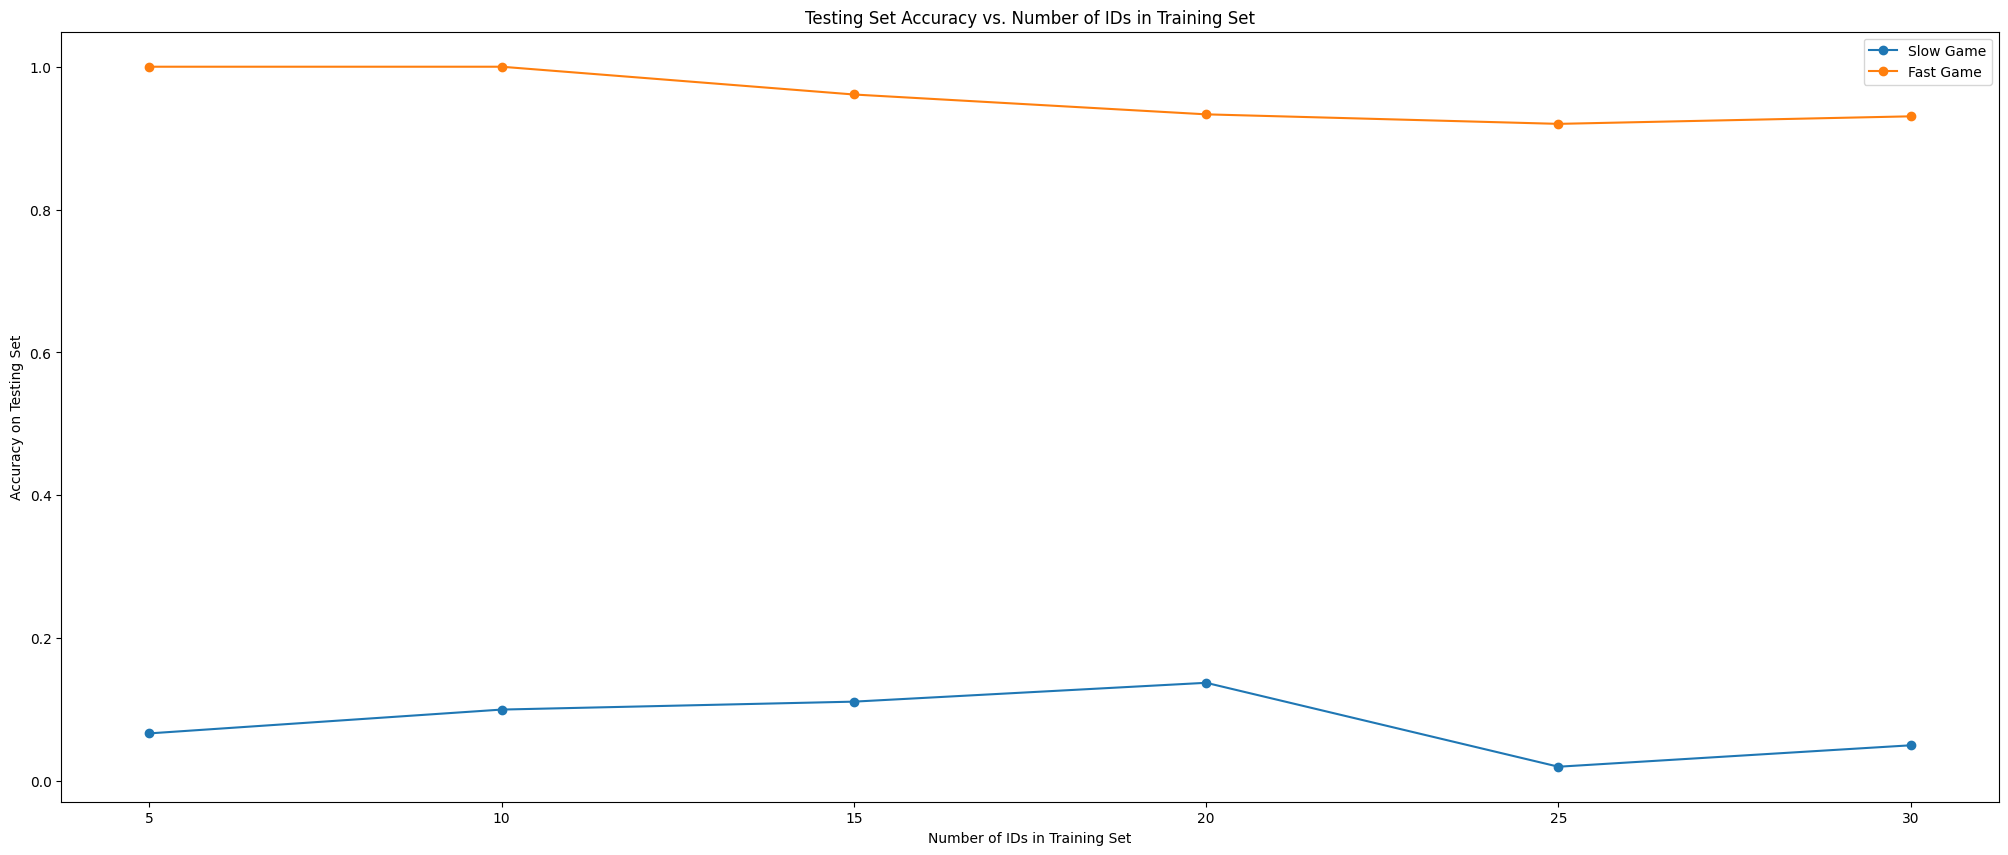


ID Over Time Data Table:


,Number of IDs in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,5,0.066667,1.000000
1,10,0.100000,1.000000
2,15,0.111111,0.961111
3,20,0.137500,0.933333
4,25,0.020000,0.920000
5,30,0.050000,0.930556


In [25]:
evaluator.accuracy_over_ids(fX_train, fy_train, best_model_fast_name, X_test, y_test,fX_test, fy_test)

### 3.1.3. Training On Forklift Simulator

In [26]:
X, y, fX, fy, X_train, y_train, X_test, y_test, fX_train, fy_train, fX_test, fy_test = evaluator.split_data(mov_slow, mov_fast, id_range=range(30,60), train_minutes=8, test_minutes=2)

Size of the training set:  (1440, 462)
Size of the slow testing set:  (360, 462)
Size of the fast training set:  (1440, 462)
Size of the fast testing set:  (360, 462)


In [27]:
Accuracy_set, models, best_model_slow, best_model_fast, cm_slow, cm_fast, best_model_slow_name, best_model_fast_name = evaluator.evaluate_classifiers(X_train,y_train,X_test,y_test,fX_test,fy_test)
Accuracy_set.sort_values(by='Accuracy(Slow)').style.background_gradient(cmap= plt.cm.Blues)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [07:05<00:00, 28.39s/it]


,Model,Accuracy(Train),Accuracy(Slow),Accuracy(Fast),F1(Train),F1(Slow),F1(Fast),Precision(Train),Precision(Slow),Precision(Fast),Recall(Train),Recall(Slow),Recall(Fast),Log_loss(Train),Log_loss(Slow),Log_loss(Fast)
11,BernoulliNB,0.061111,0.052778,0.033333,0.046162,0.017421,0.002319,0.381199,0.013508,0.001201,0.061111,0.052778,0.033333,3.342178,3.365254,3.417192
9,QuadraticDiscriminantAnalysis,1.000000,0.141667,0.036111,1.000000,0.144940,0.034604,1.000000,0.185423,0.042613,1.000000,0.141667,0.036111,0.000000,30.937469,34.742077
7,AdaBoostClassifier,0.300000,0.294444,0.072222,0.246561,0.243531,0.036296,0.240850,0.240850,0.027905,0.300000,0.294444,0.072222,2.419416,2.432156,6.105149
0,SVC,0.715972,0.744444,0.038889,0.704475,0.725388,0.017852,0.803133,0.802142,0.012894,0.715972,0.744444,0.038889,3.410287,3.410460,3.402387
3,DecisionTreeClassifier,1.000000,0.836111,0.047222,1.000000,0.828552,0.034132,1.000000,0.843568,0.035722,1.000000,0.836111,0.047222,0.000000,5.907154,34.341592
8,GaussianNB,0.915972,0.852778,0.041667,0.914353,0.851542,0.011267,0.928477,0.880099,0.010026,0.915972,0.852778,0.041667,2.328845,5.016398,34.541834
4,KNeighborsClassifier,0.955556,0.900000,0.036111,0.955700,0.898712,0.014155,0.959065,0.917378,0.008843,0.955556,0.900000,0.036111,0.153016,1.104038,32.841512
12,BaggingClassifier,0.999306,0.902778,0.036111,0.999305,0.897500,0.034159,0.999320,0.924051,0.034413,0.999306,0.902778,0.036111,0.047771,1.043120,29.311818
6,MLPClassifier,0.971528,0.927778,0.036111,0.971360,0.927710,0.018362,0.972366,0.939893,0.021186,0.971528,0.927778,0.036111,0.213729,0.340968,16.524938
13,LGBMClassifier,1.000000,0.947222,0.033333,1.000000,0.947464,0.011821,1.000000,0.954750,0.007207,1.000000,0.947222,0.033333,0.000018,0.235997,11.470965


In [28]:
explainer = shap.TreeExplainer(best_model_slow)
shap_values_slow = explainer.shap_values(X_test)

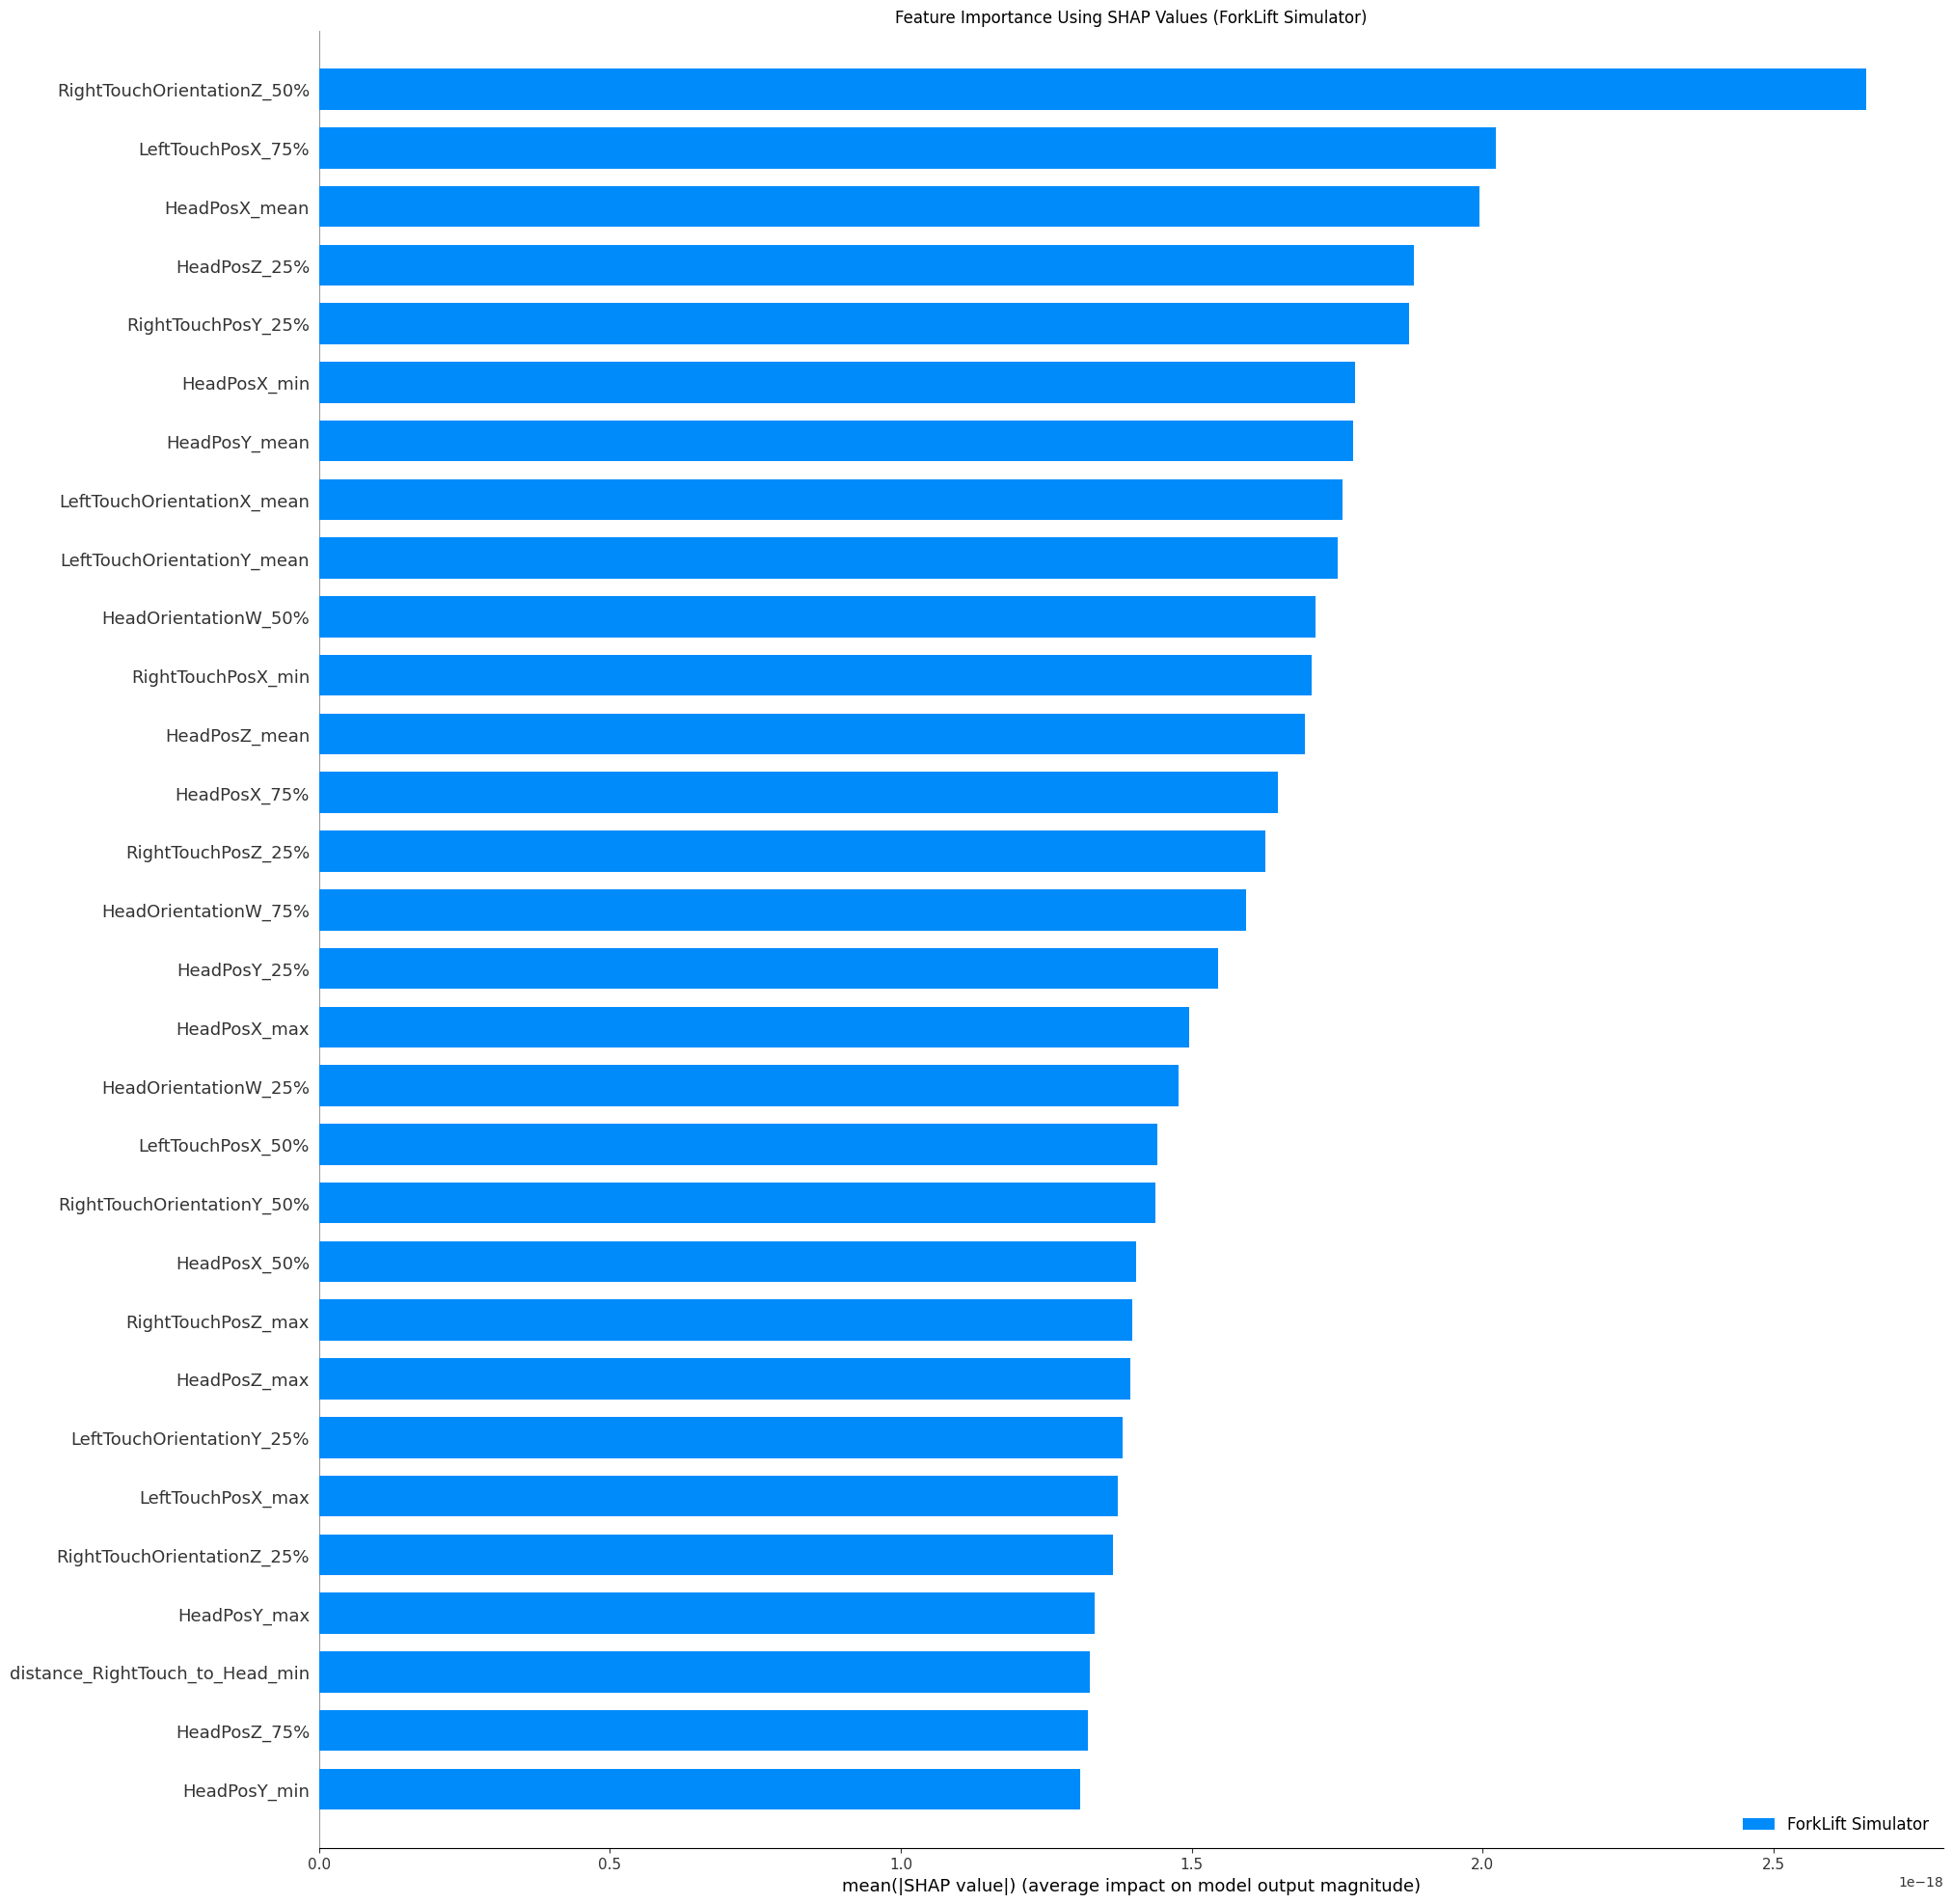

In [29]:
VisualizationUtils.shap_plotter([np.mean(shap_values_slow, axis=2)], 
                          X_test, title="Feature Importance Using SHAP Values (ForkLift Simulator)",
                          class_names=['ForkLift Simulator'])

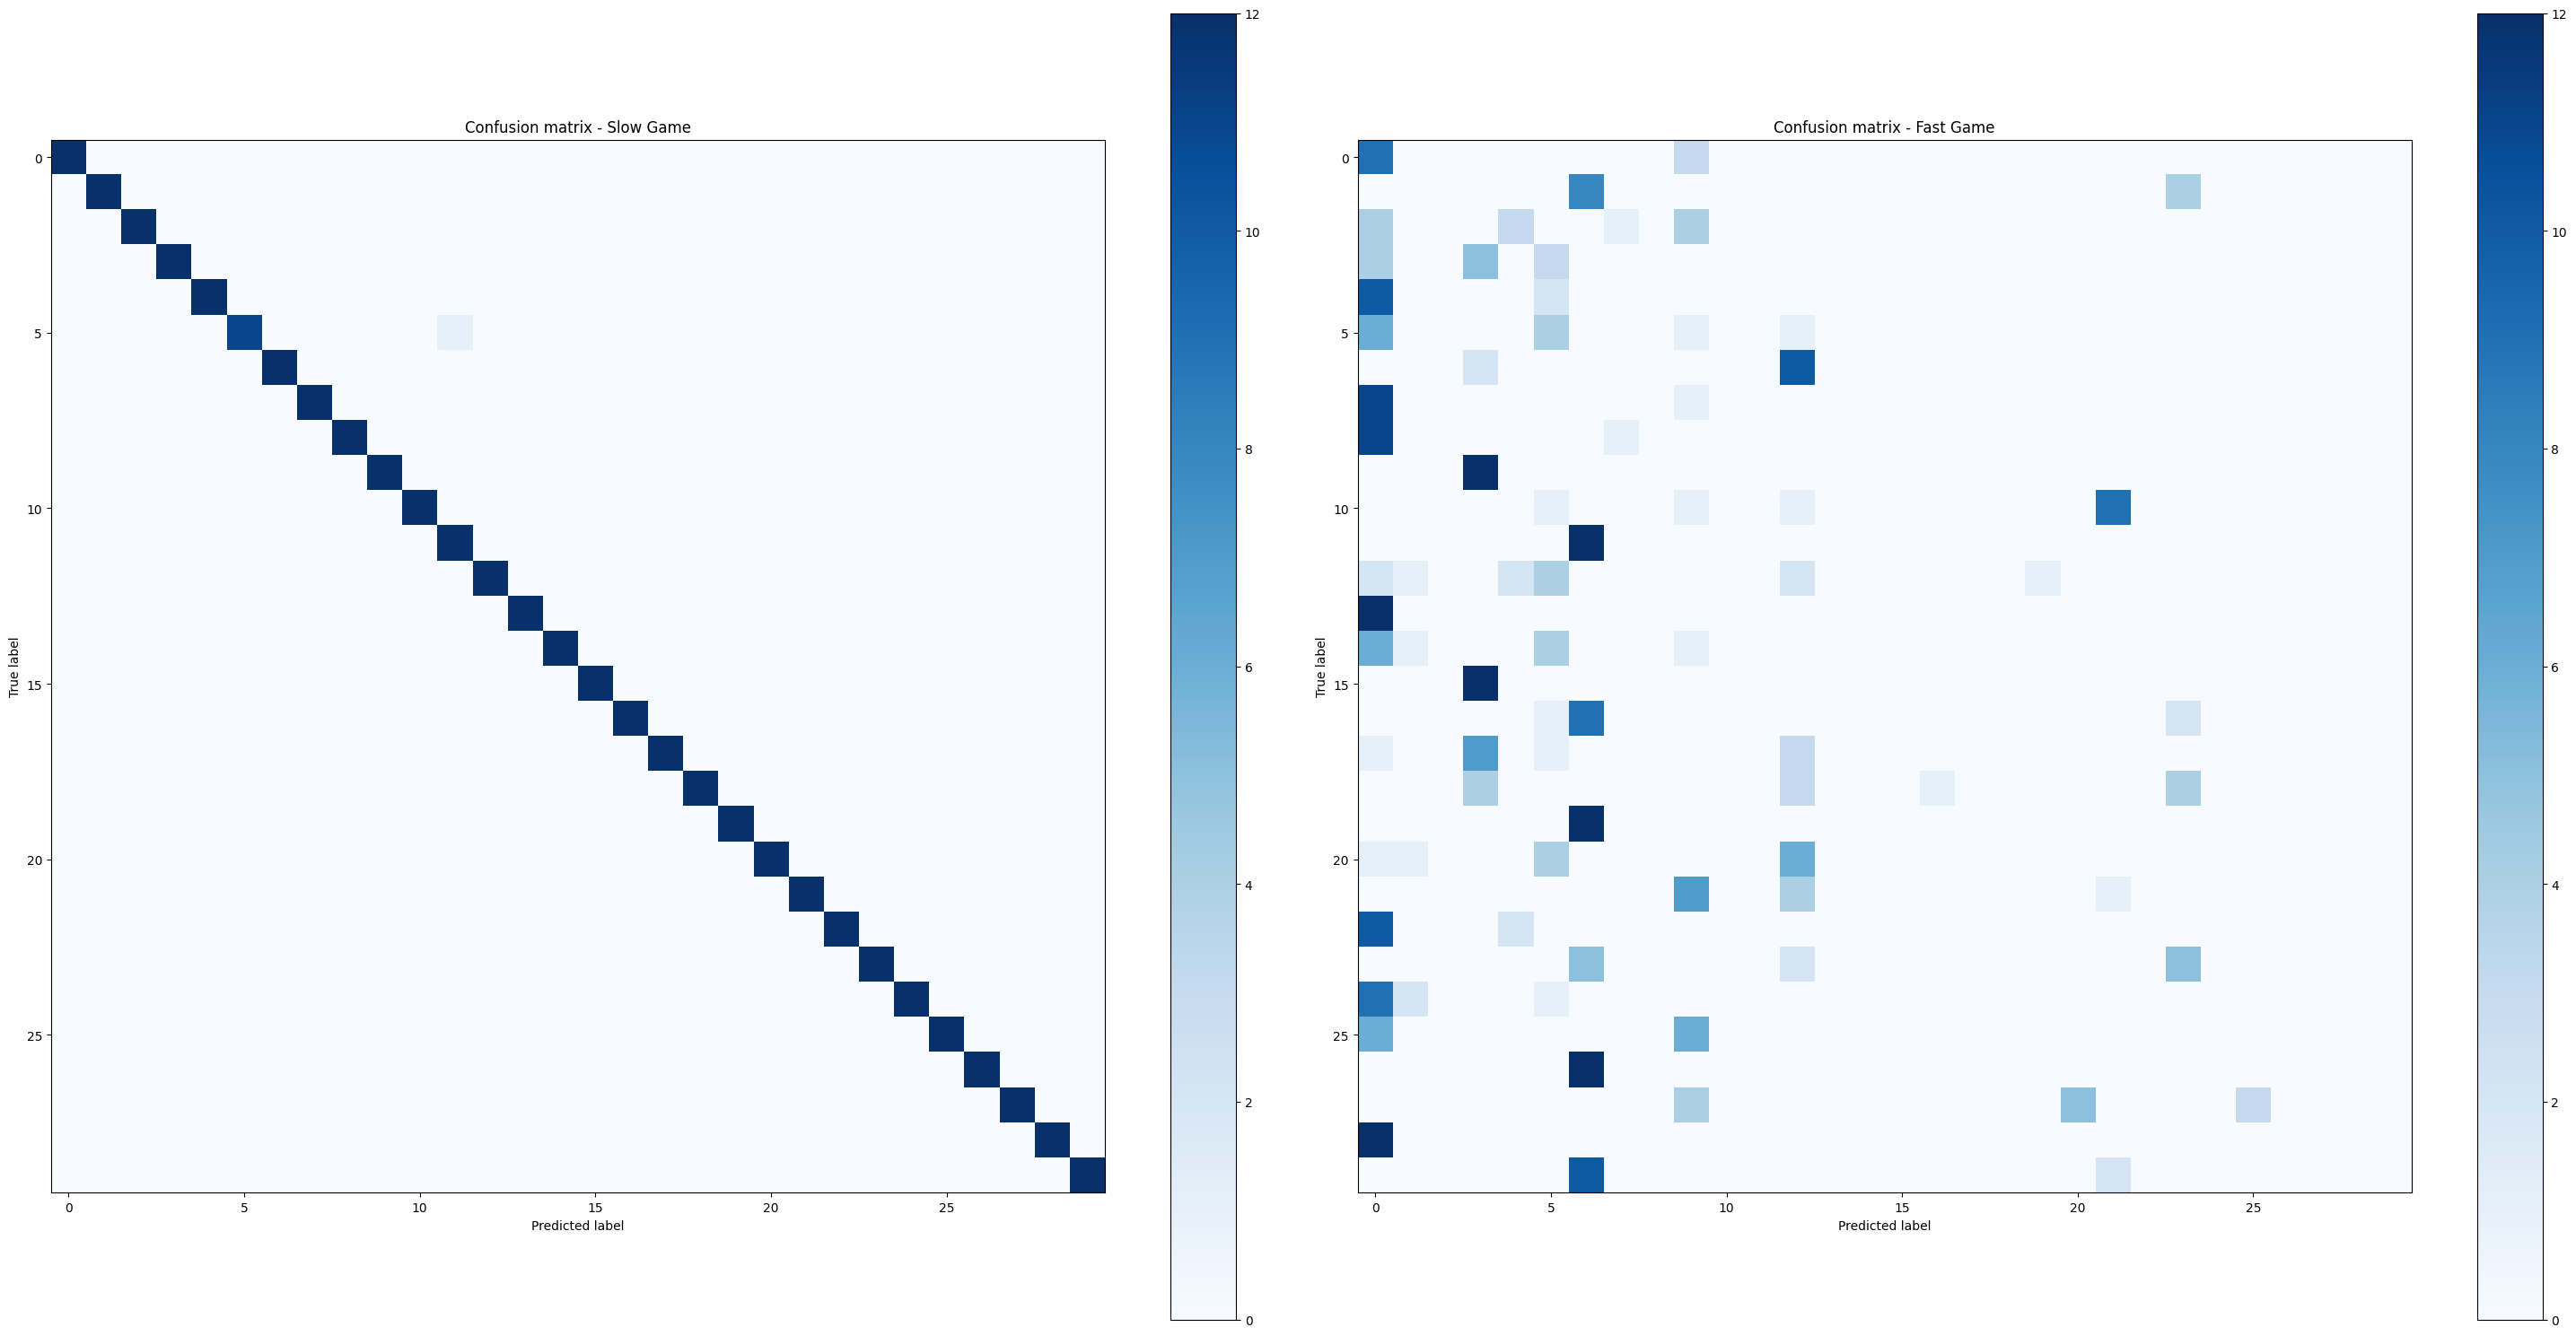

In [30]:
VisualizationUtils.confusion_matrices(cm_slow, cm_fast)

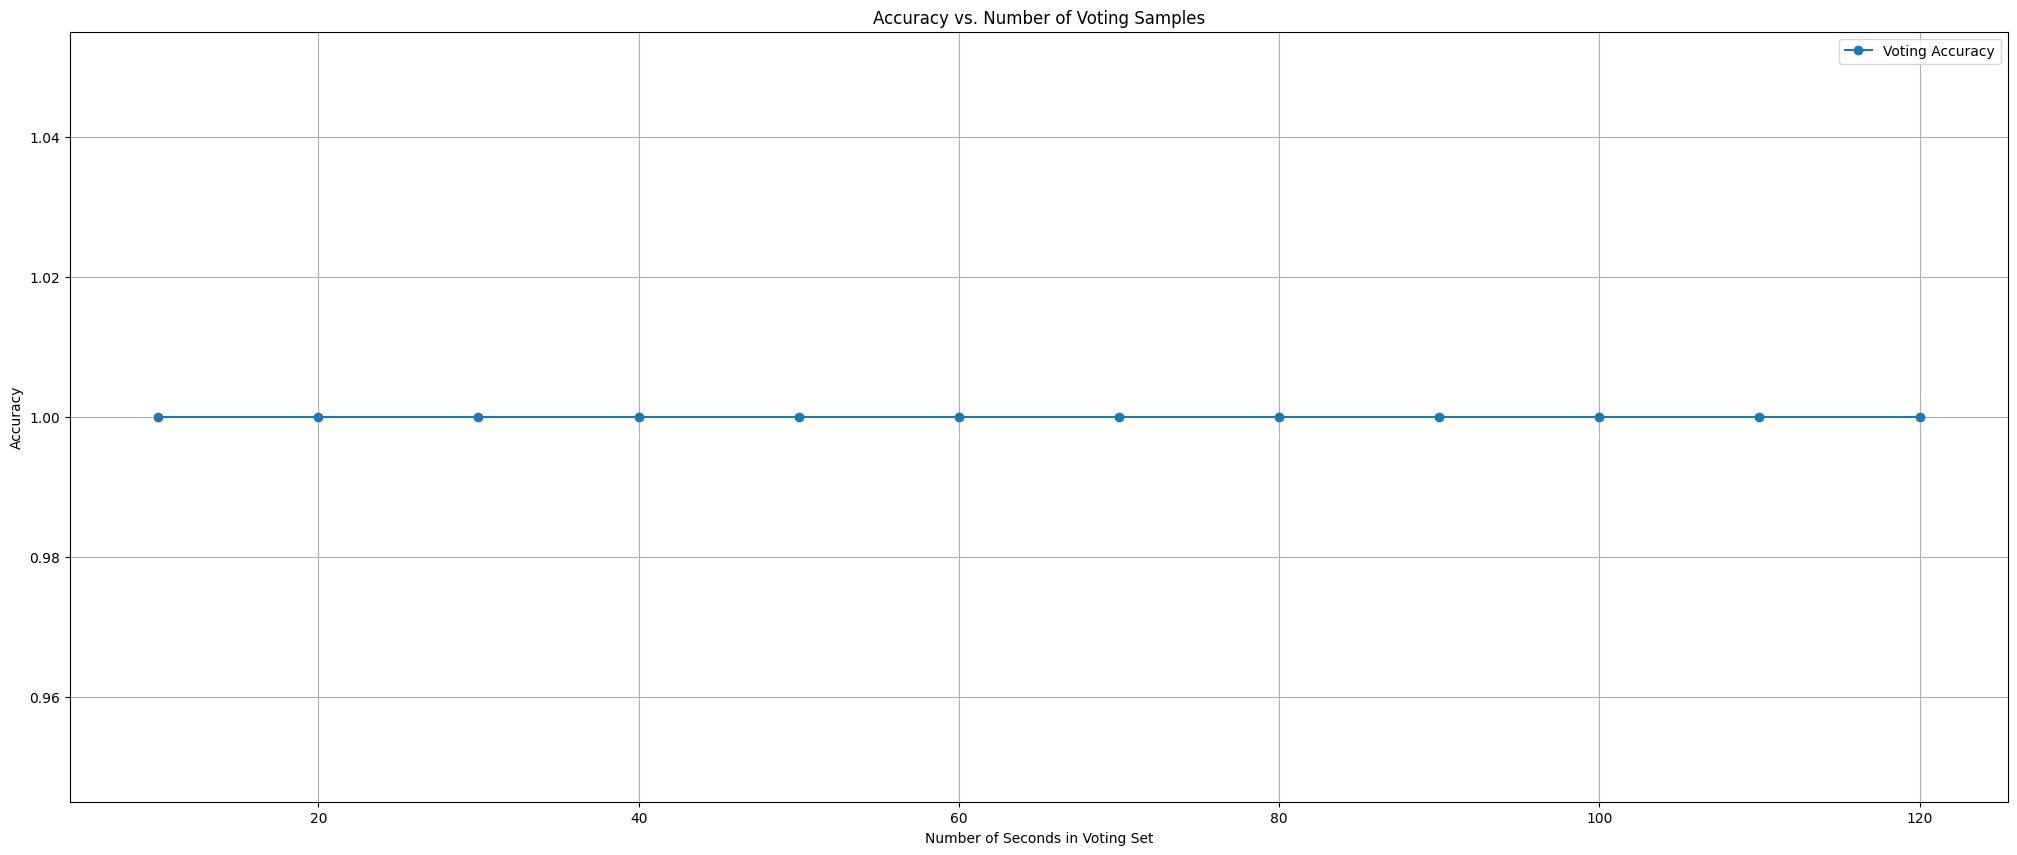


Vote Over Time Data Table:


,Seconds in Voting Set,Voting Accuracy
0,10,1.0
1,20,1.0
2,30,1.0
3,40,1.0
4,50,1.0
5,60,1.0
6,70,1.0
7,80,1.0
8,90,1.0
9,100,1.0


In [31]:
evaluator.plot_accuracy_by_vote(best_model_slow, X_test, y_test, increment=1)

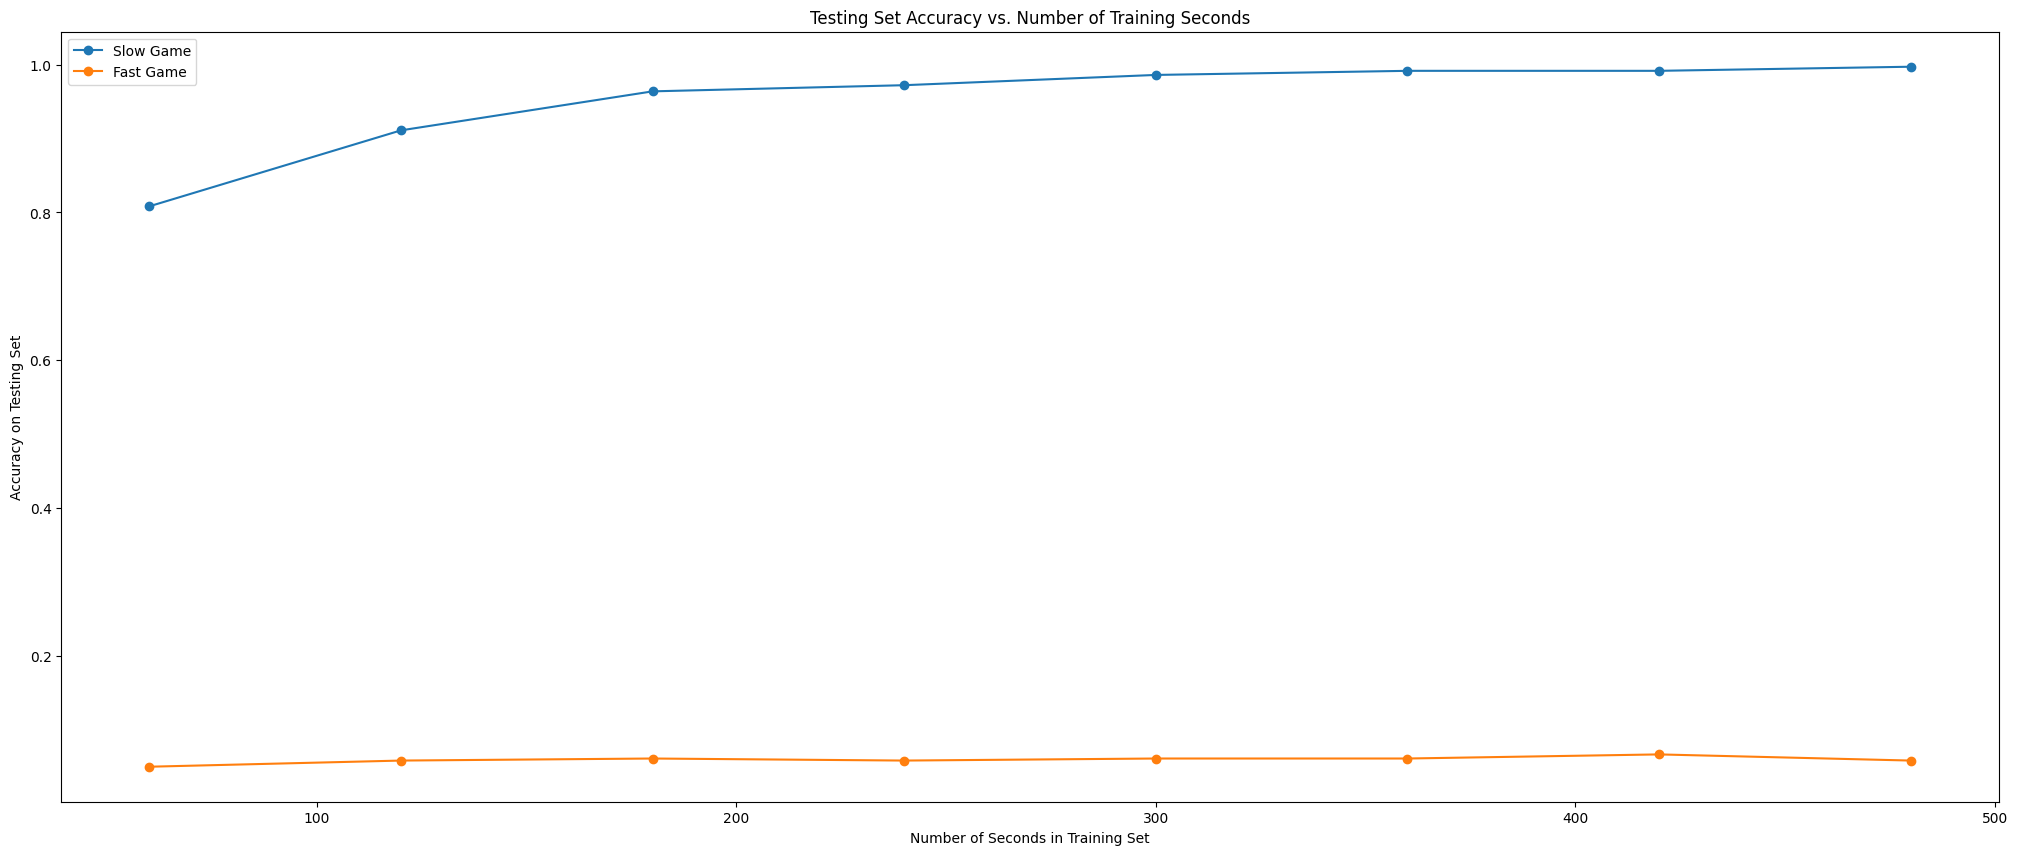


Accuracy Over Time Data Table:


,Seconds in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,60,0.808333,0.050000
1,120,0.911111,0.058333
2,180,0.963889,0.061111
3,240,0.972222,0.058333
4,300,0.986111,0.061111
5,360,0.991667,0.061111
6,420,0.991667,0.066667
7,480,0.997222,0.058333


In [32]:
evaluator.accuracy_over_time(X, y,best_model_slow_name, range(1,9), X_test, y_test, fX_test, fy_test)

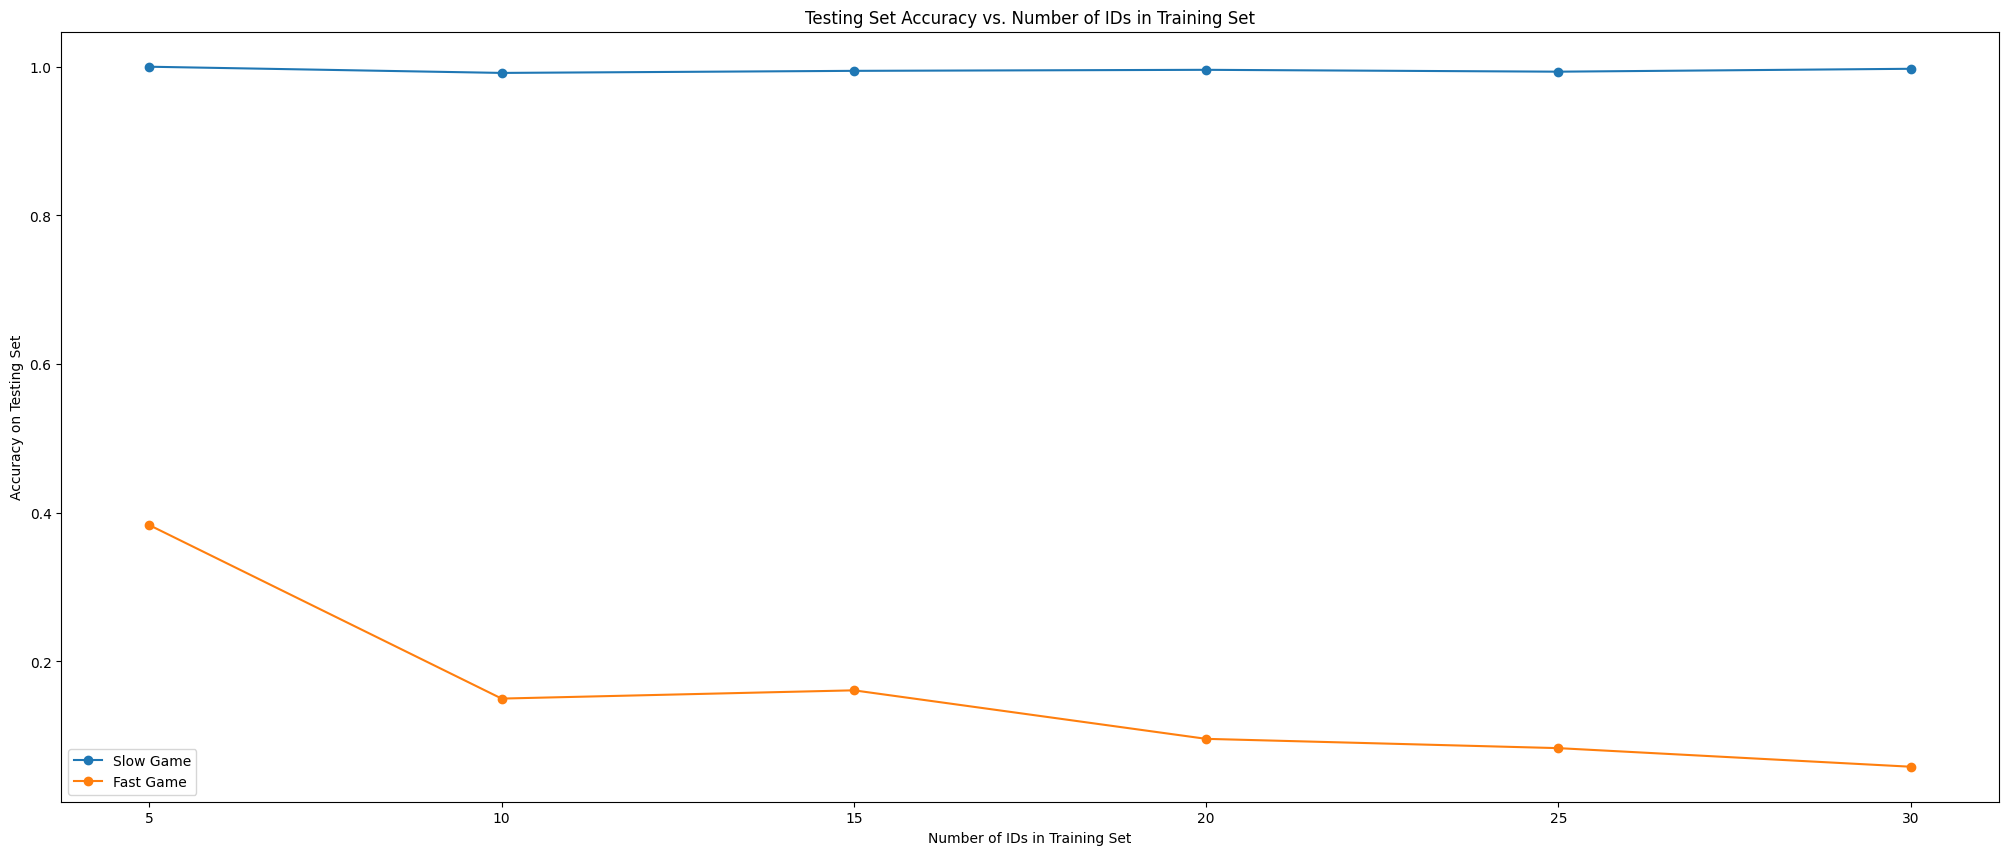


ID Over Time Data Table:


,Number of IDs in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,5,1.000000,0.383333
1,10,0.991667,0.150000
2,15,0.994444,0.161111
3,20,0.995833,0.095833
4,25,0.993333,0.083333
5,30,0.997222,0.058333


In [33]:
evaluator.accuracy_over_ids(X_train, y_train,best_model_slow_name, X_test, y_test,fX_test, fy_test)

### 3.1.4. Training On Medal of Honor

In [34]:
Accuracy_set, models, best_model_slow, best_model_fast, cm_slow, cm_fast, best_model_slow_name, best_model_fast_name = evaluator.evaluate_classifiers(fX_train,fy_train,X_test,y_test,fX_test,fy_test)
Accuracy_set.sort_values(by='Accuracy(Fast)').style.background_gradient(cmap= plt.cm.Blues)

100%|██████████| 15/15 [06:51<00:00, 27.42s/it]


,Model,Accuracy(Train),Accuracy(Slow),Accuracy(Fast),F1(Train),F1(Slow),F1(Fast),Precision(Train),Precision(Slow),Precision(Fast),Recall(Train),Recall(Slow),Recall(Fast),Log_loss(Train),Log_loss(Slow),Log_loss(Fast)
11,BernoulliNB,0.115278,0.027778,0.044444,0.114992,0.001927,0.019006,0.587099,0.000998,0.034545,0.115278,0.027778,0.044444,3.307568,4.136374,4.089004
9,QuadraticDiscriminantAnalysis,1.000000,0.041667,0.061111,1.000000,0.029513,0.060788,1.000000,0.026600,0.074878,1.000000,0.041667,0.061111,0.000000,34.541834,33.840986
7,AdaBoostClassifier,0.106944,0.041667,0.097222,0.051521,0.006116,0.042292,0.079982,0.003452,0.039050,0.106944,0.041667,0.097222,2.887262,6.106587,3.008065
0,SVC,0.637500,0.094444,0.388889,0.618075,0.042689,0.359865,0.696737,0.055418,0.405008,0.637500,0.094444,0.388889,3.416907,3.403817,3.413104
3,DecisionTreeClassifier,1.000000,0.116667,0.447222,1.000000,0.069206,0.423066,1.000000,0.059149,0.454398,1.000000,0.116667,0.447222,0.000000,31.838560,19.924131
8,GaussianNB,0.773611,0.047222,0.488889,0.756542,0.007894,0.450808,0.813201,0.004360,0.543750,0.773611,0.047222,0.488889,7.140121,34.035356,17.012821
12,BaggingClassifier,0.998611,0.113889,0.527778,0.998611,0.060569,0.510147,0.998639,0.045363,0.534041,0.998611,0.113889,0.527778,0.138313,26.542479,7.224484
4,KNeighborsClassifier,0.827083,0.063889,0.544444,0.824882,0.023578,0.525419,0.837184,0.017154,0.539022,0.827083,0.063889,0.544444,0.497944,30.522689,9.834475
5,RandomForestClassifier,1.000000,0.155556,0.633333,1.000000,0.071638,0.605785,1.000000,0.048167,0.623289,1.000000,0.155556,0.633333,0.168105,13.693489,1.761382
6,MLPClassifier,0.984722,0.122222,0.650000,0.984658,0.060320,0.634822,0.984985,0.052968,0.681295,0.984722,0.122222,0.650000,0.126587,8.212722,1.364699


In [35]:
explainer = shap.TreeExplainer(best_model_fast)
shap_values_fast = explainer.shap_values(fX_test)

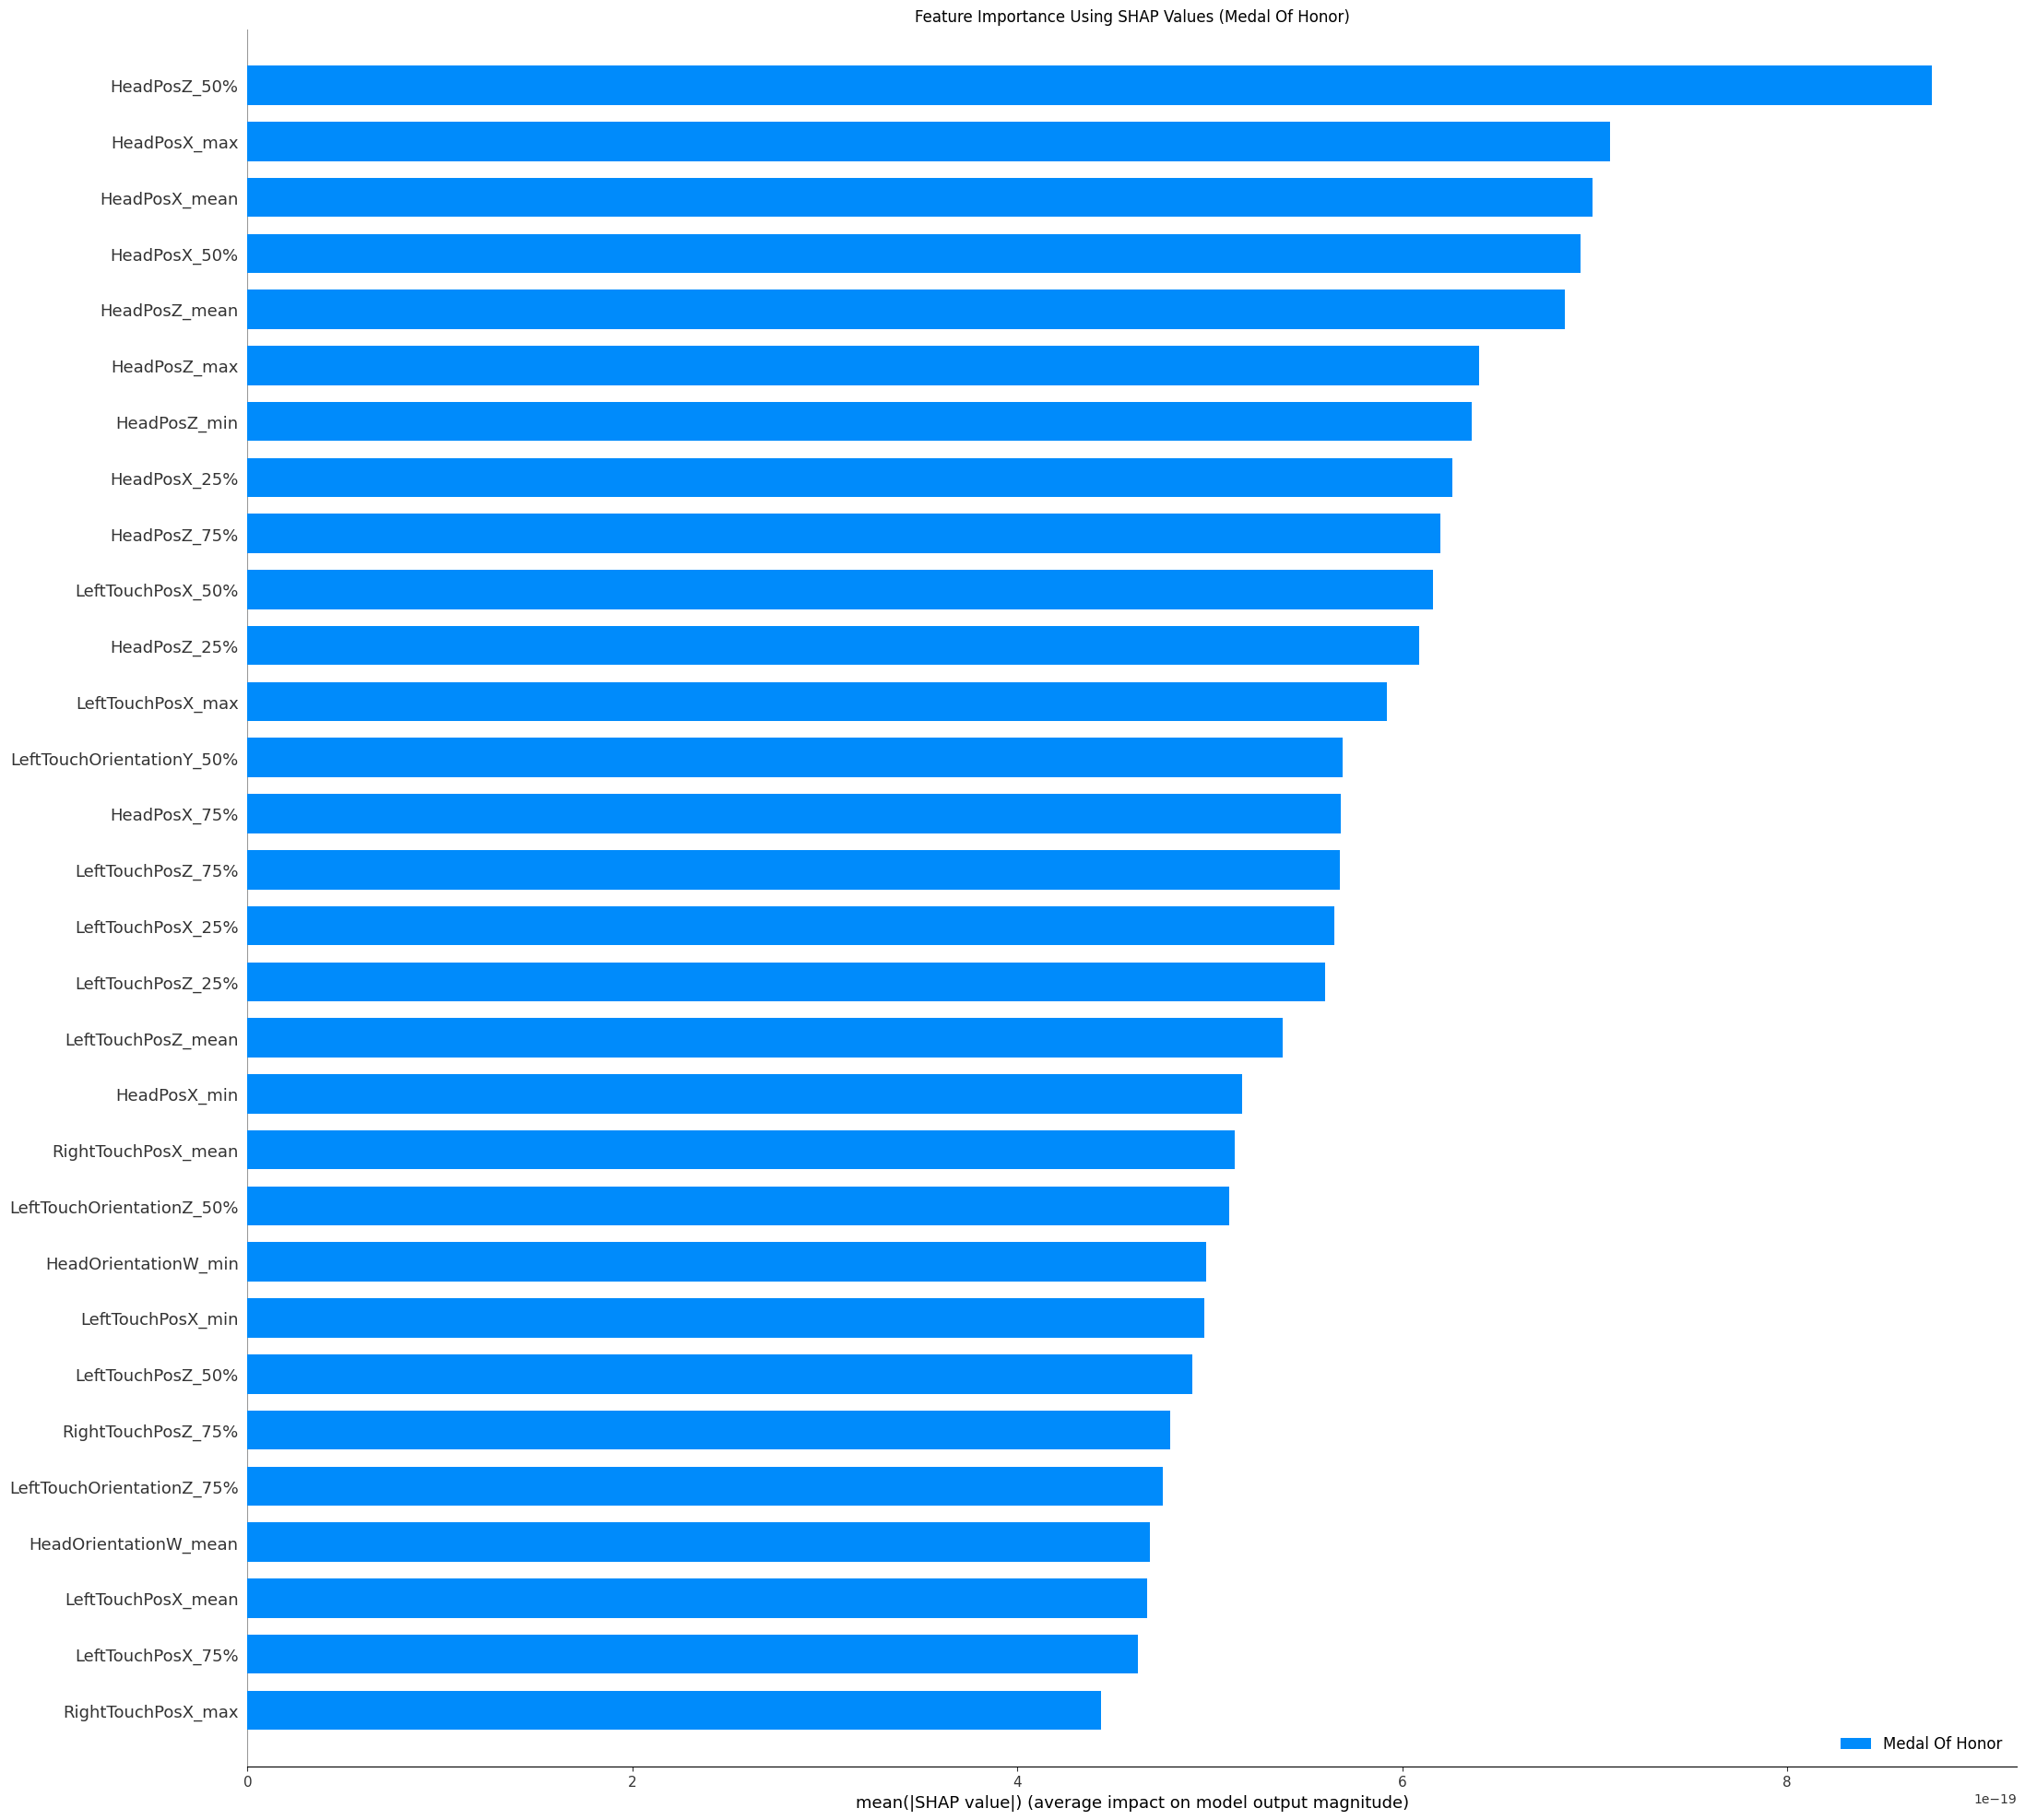

In [36]:
VisualizationUtils.shap_plotter([np.mean(shap_values_fast, axis=2)], 
                          fX_test, title="Feature Importance Using SHAP Values (Medal Of Honor)",
                          class_names=['Medal Of Honor'])

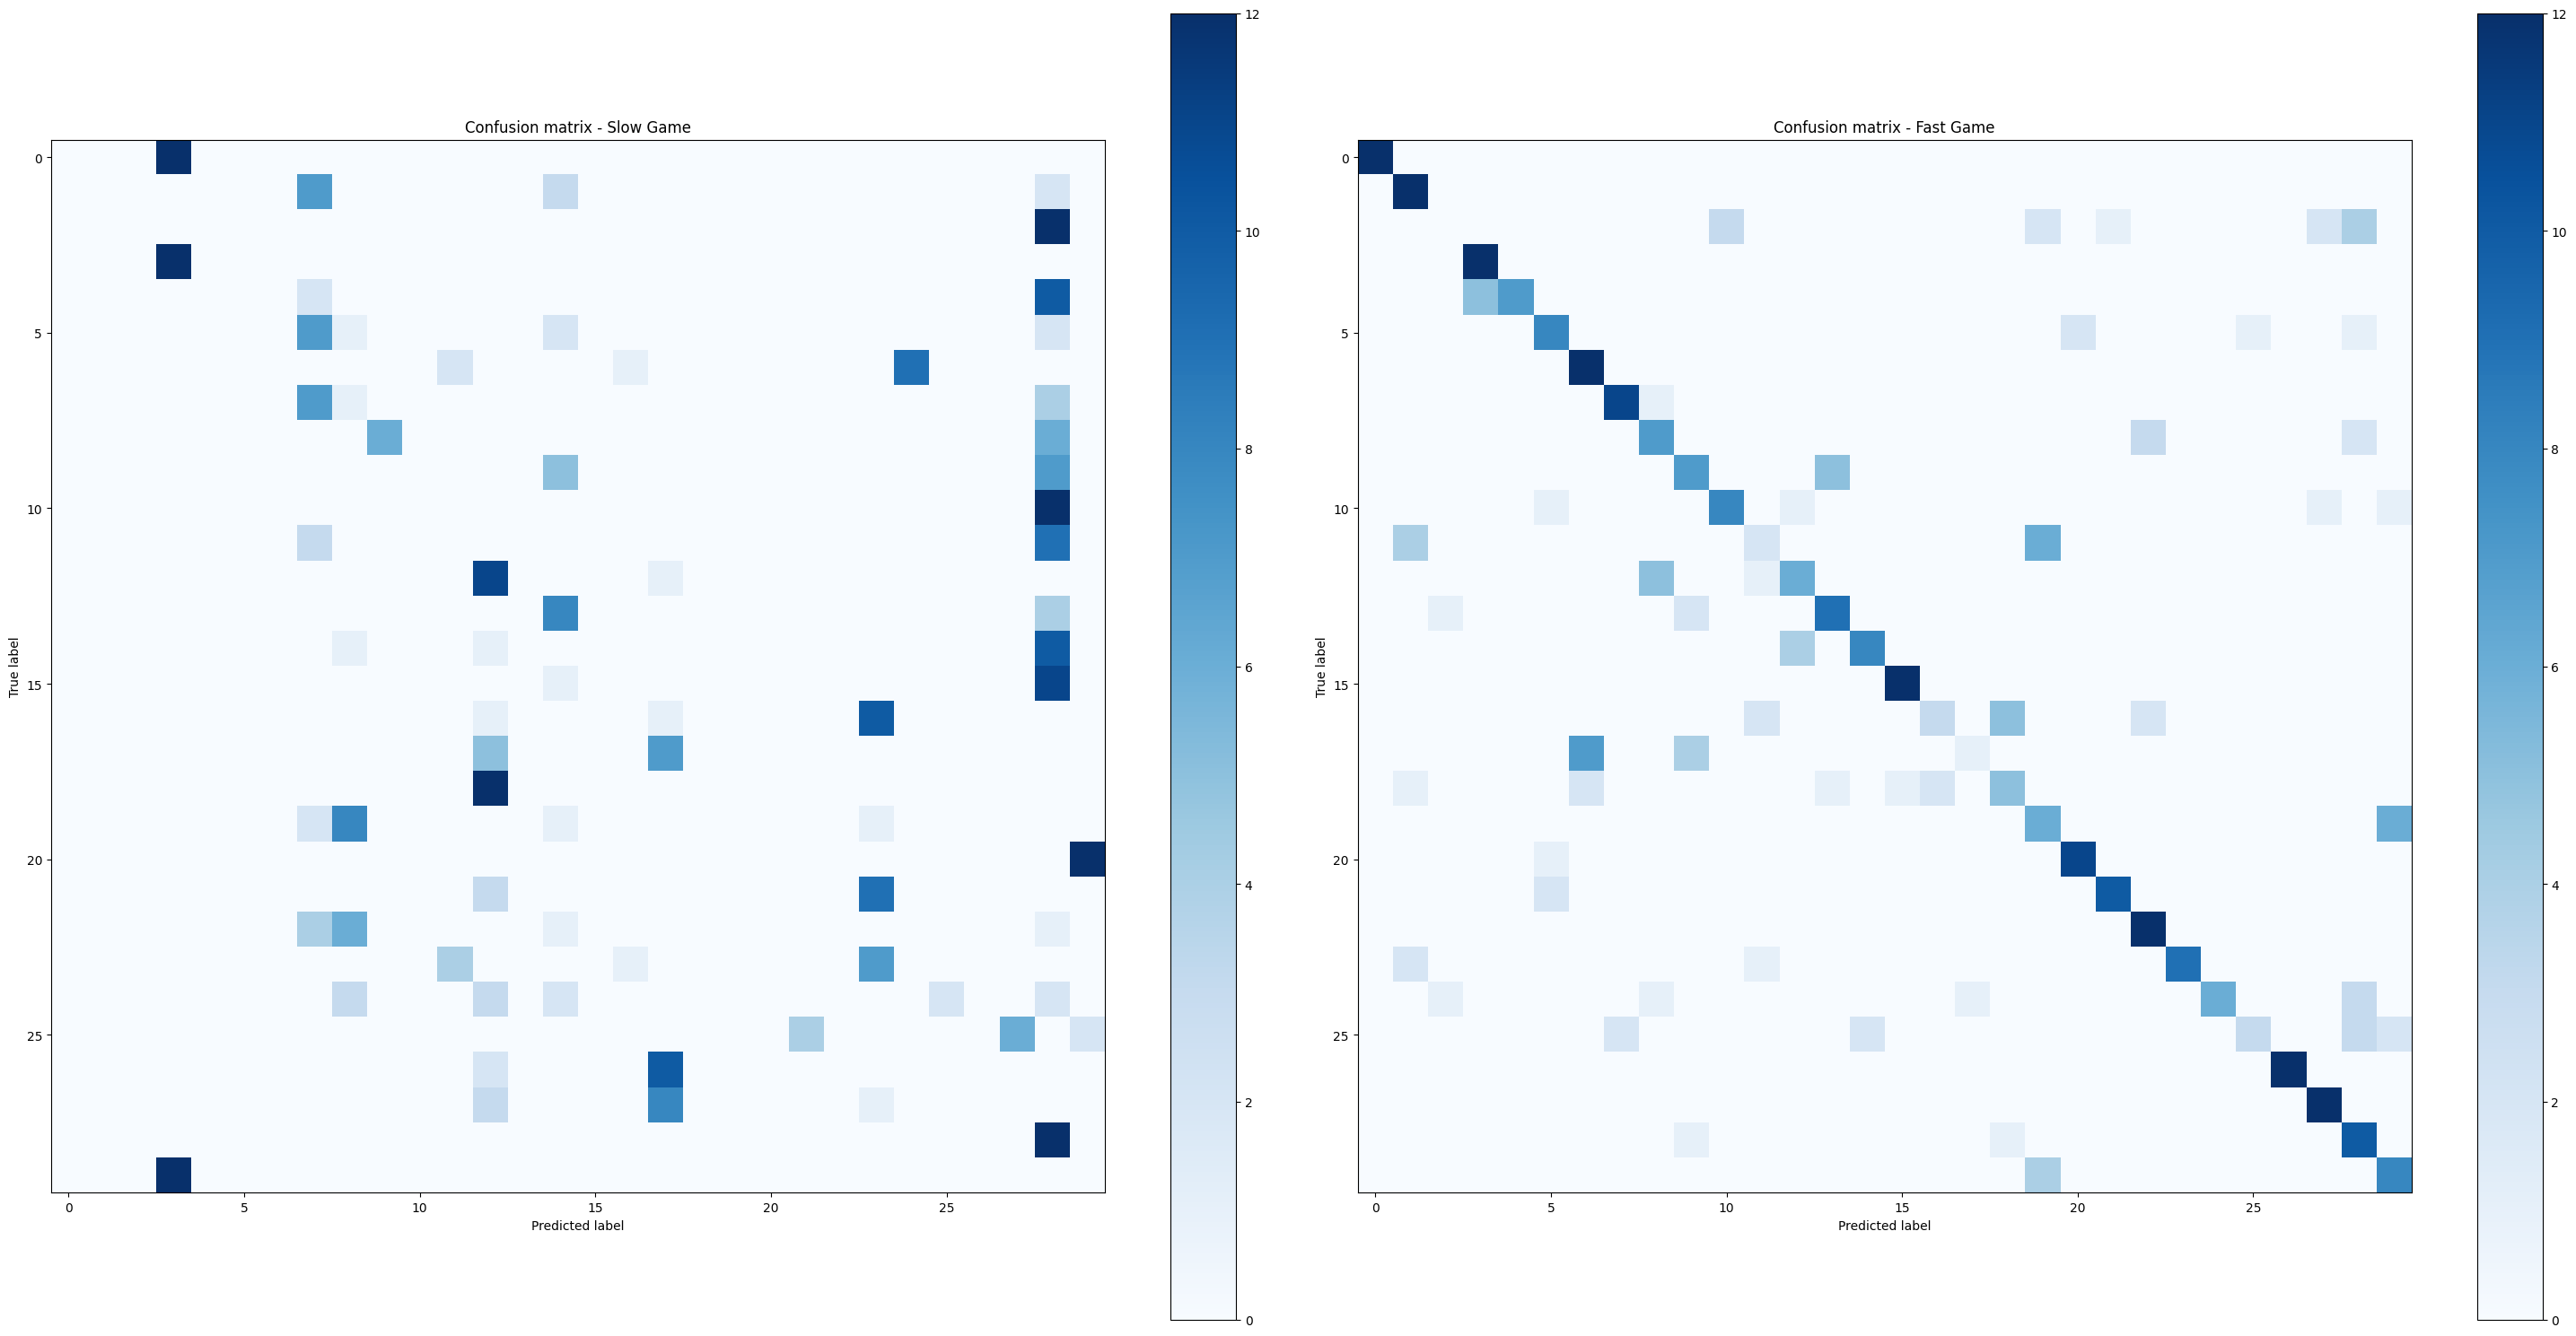

In [37]:
VisualizationUtils.confusion_matrices(cm_slow, cm_fast)

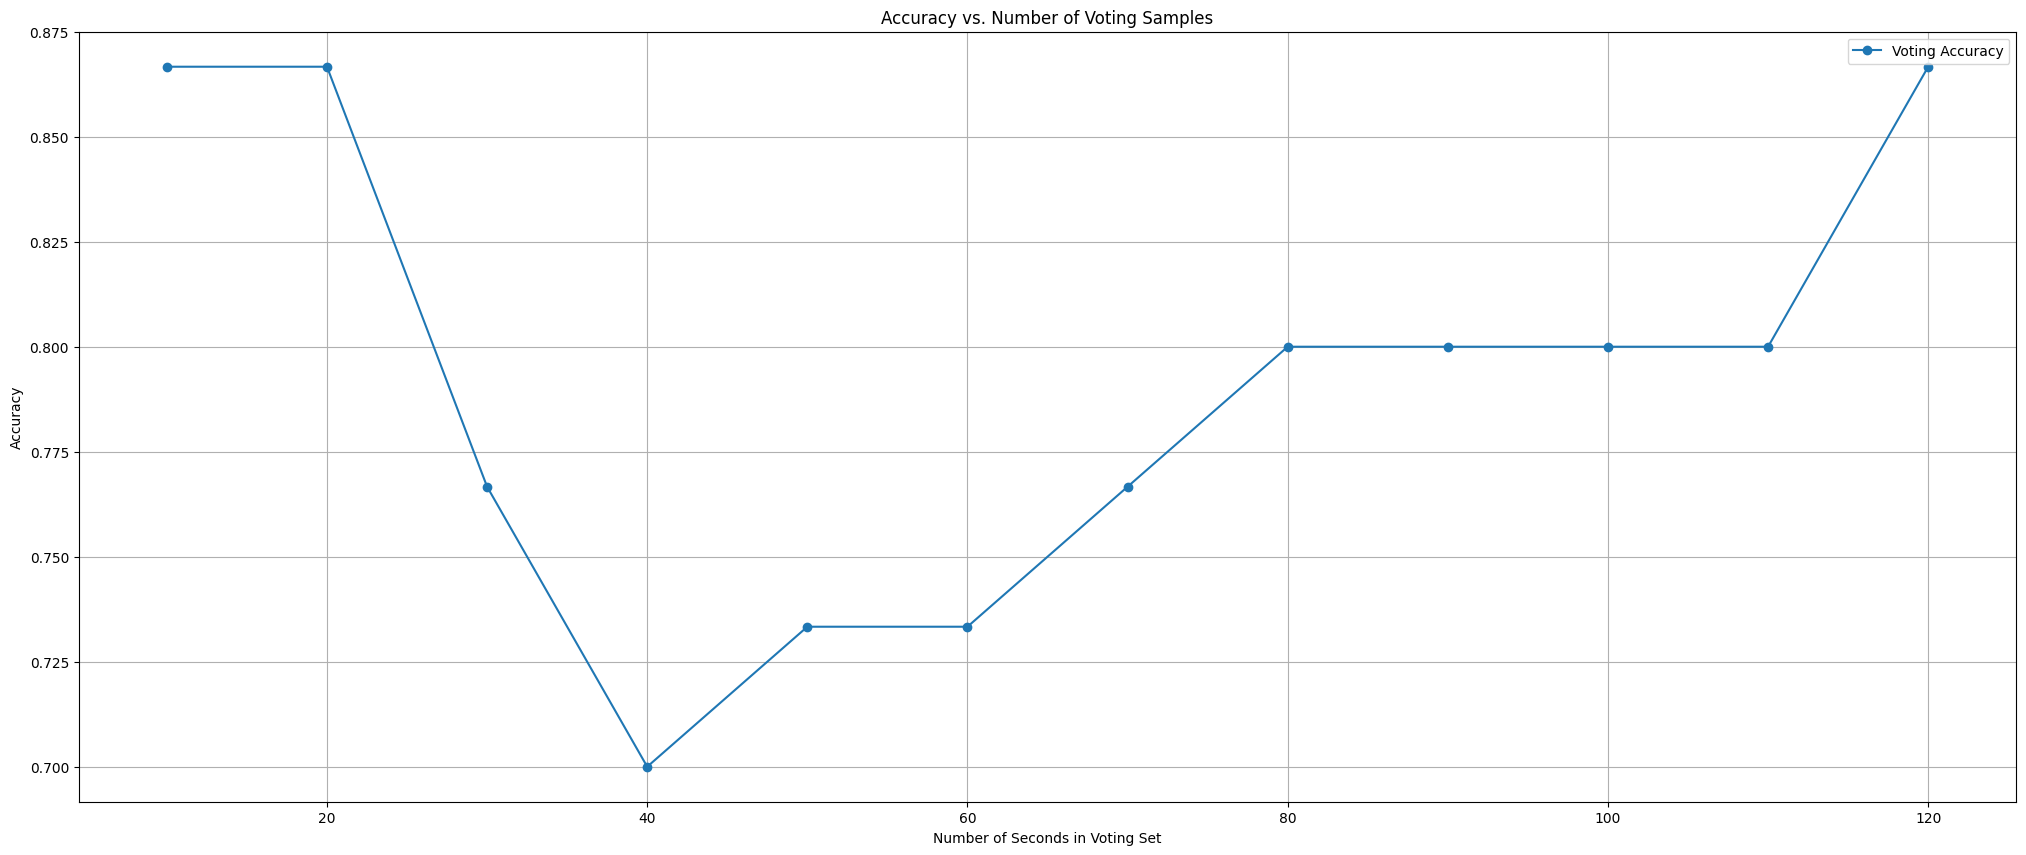


Vote Over Time Data Table:


,Seconds in Voting Set,Voting Accuracy
0,10,0.866667
1,20,0.866667
2,30,0.766667
3,40,0.700000
4,50,0.733333
5,60,0.733333
6,70,0.766667
7,80,0.800000
8,90,0.800000
9,100,0.800000


In [38]:
evaluator.plot_accuracy_by_vote(best_model_fast, fX_test, fy_test, increment=1)

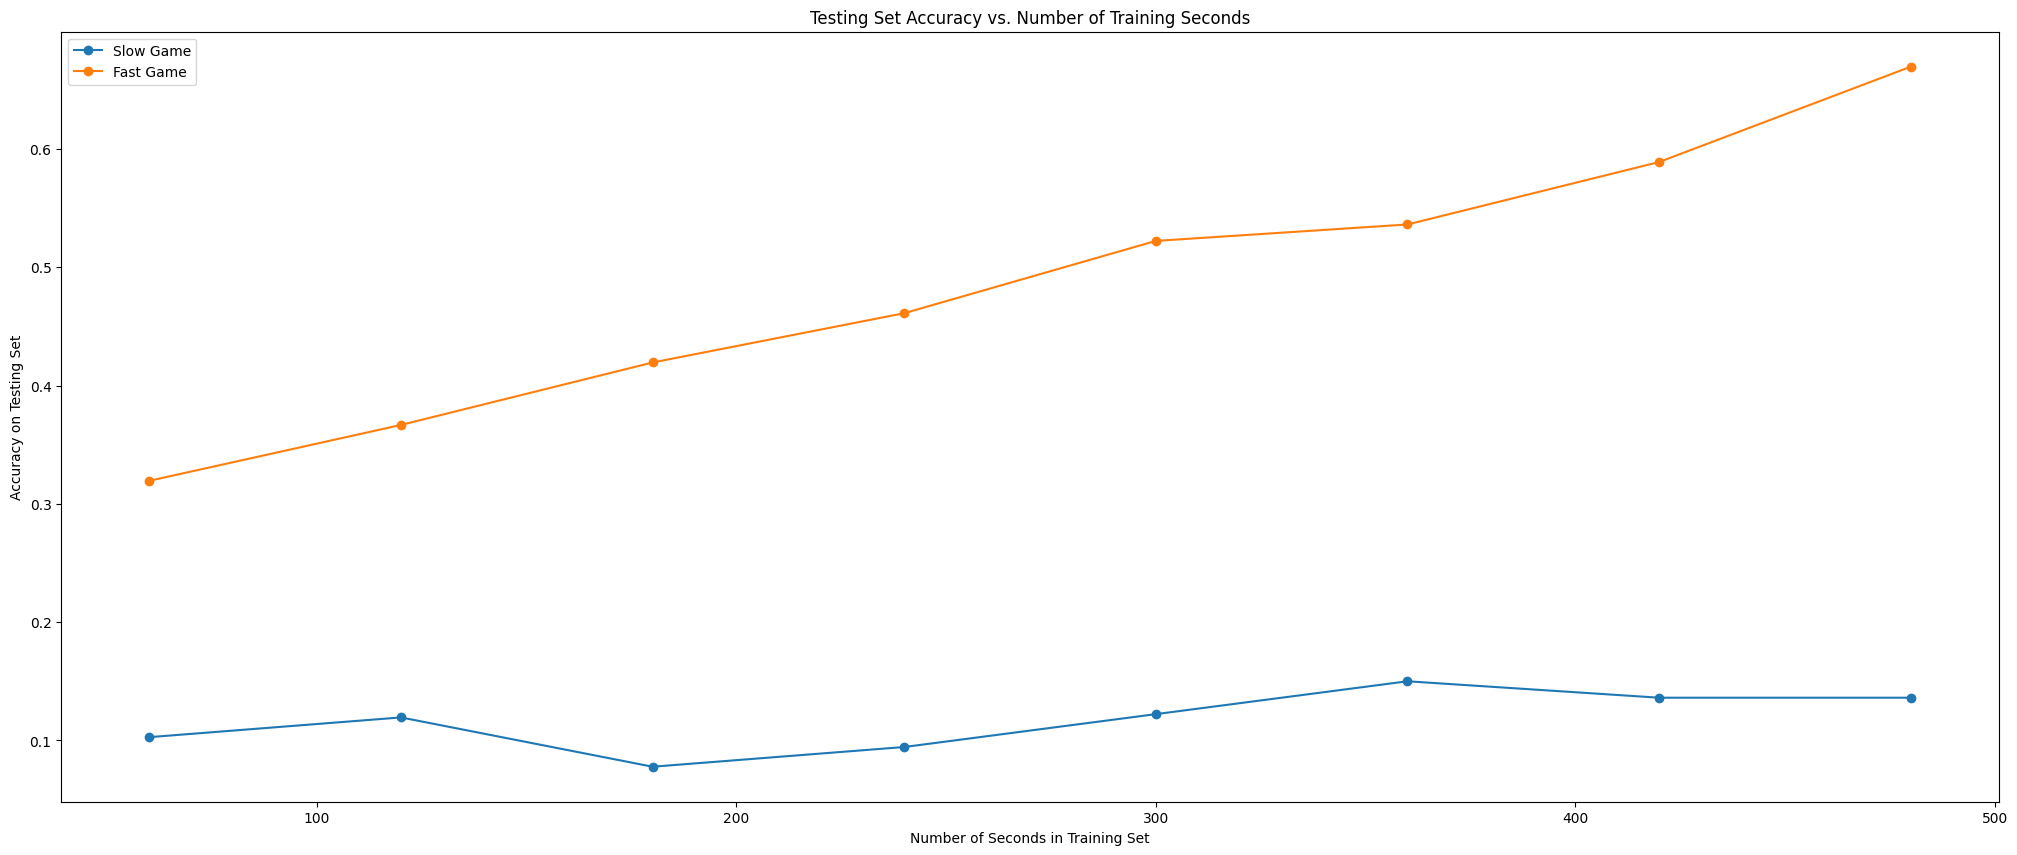


Accuracy Over Time Data Table:


,Seconds in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,60,0.102778,0.319444
1,120,0.119444,0.366667
2,180,0.077778,0.419444
3,240,0.094444,0.461111
4,300,0.122222,0.522222
5,360,0.150000,0.536111
6,420,0.136111,0.588889
7,480,0.136111,0.669444


In [39]:
evaluator.accuracy_over_time(fX, fy,best_model_fast_name, range(1,9), X_test, y_test, fX_test, fy_test)

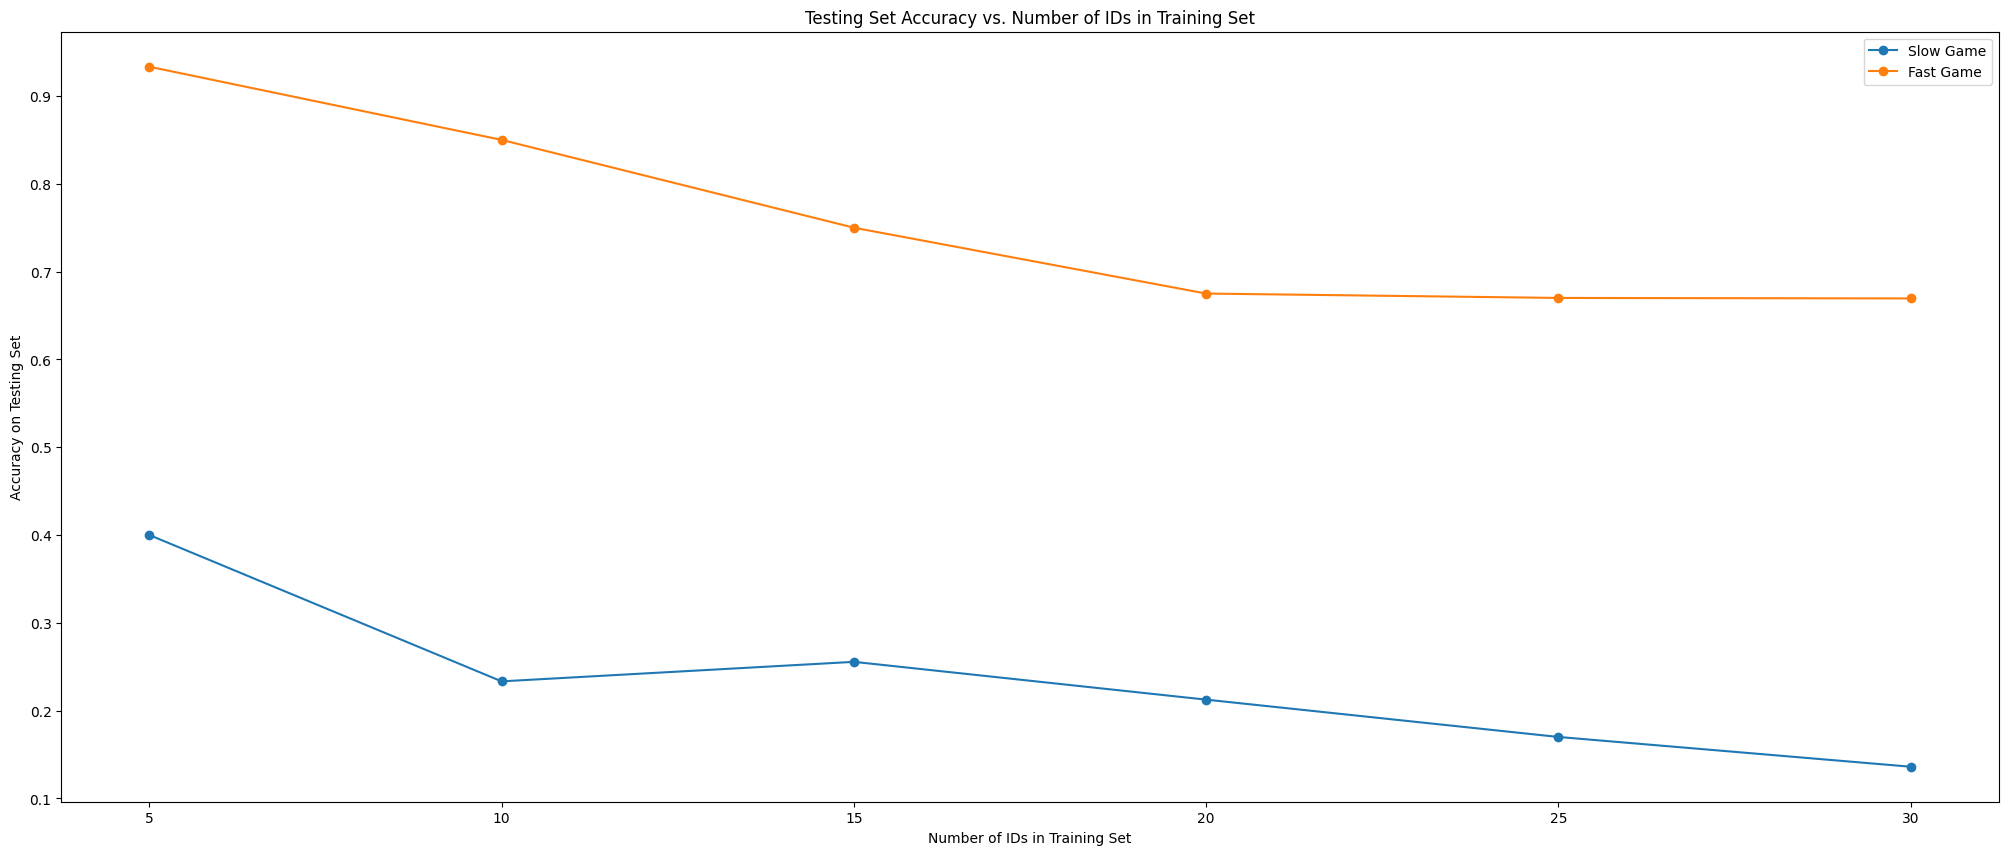


ID Over Time Data Table:


,Number of IDs in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,5,0.400000,0.933333
1,10,0.233333,0.850000
2,15,0.255556,0.750000
3,20,0.212500,0.675000
4,25,0.170000,0.670000
5,30,0.136111,0.669444


In [40]:
evaluator.accuracy_over_ids(fX_train, fy_train,best_model_fast_name, X_test, y_test,fX_test, fy_test)